# ***Deep Learning - Assignment 4***

Student name - Leor Ariel Rose, ID - 208373365

Student name - Aviv Rovshitz, ID - 307974162

### ***Import packages***

Let's begin with importing all necessary packages:

In [1]:
# Data reading
import numpy as np
import pandas as pd
from scipy.io import arff

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

# Deep learning
import tensorflow as tf
from tensorflow.keras import (
    Model, Sequential, layers, activations, initializers, optimizers, losses,
    metrics, utils
)

# scikit-learn
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, MinMaxScaler)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, train_test_split
)

# EDA
from pandas_profiling import ProfileReport

# Synthetic data evaluation
from table_evaluator import TableEvaluator

# Typing
from typing import Tuple, List, Dict, Any

# Randomness
import random

### ***Consistency***

Next, let's make sure notebook is not random:

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### ***Constant definitions***

Next, let's define some constant variables:

In [3]:
# Define the path containing the Data (german_credit.arff, diabetes.arff)
DATA_PATH = "./Data"

# Define the path containing the diabetes data
DIABETES_PATH = f"{DATA_PATH}/diabetes.arff"

# Define the path containing the german credit data
GERMAN_CREDIT_PATH = f"{DATA_PATH}/german_credit.arff"

# Define batch size
BATCH_SIZE = 32

# Define learning rate
LEARNING_RATE = 0.0002

# Define momentum rate
MOMENTUM_RATE = 0.5

# Define number of epochs
DIABETES_NUM_EPOCHS = 1200
G_CREDIT_NUM_EPOCHS = 200
TWIST_NUM_EPOCHS = 400

# Define label smoothing value
LABEL_SMOOTHING = 0.1

# Define size of test set
TEST_SIZE = 0.3

# Define weight initialization object
WEIGHT_INIT = initializers.RandomNormal(mean=0.0, stddev=0.02)

### ***Auxiliary methods***

Next, let's define some auxiliary methods:

In [4]:
def read_arff(file_path: str) -> pd.DataFrame:
  """Method to read arff file as data frame.

  Args:
    file_path (str): Path to arff file.

  Returns:
    pd.DataFrame: Read data.

  """
  # Load arff data
  data, meta = arff.loadarff(file_path)
  # Create data frame from data and column names
  arff_df = pd.DataFrame(data, columns=meta.names())
  # Decode byte objects to strings
  for n, t in zip(meta.names(), meta.types()):
    if t == "nominal":
      arff_df[n] = arff_df[n].str.decode("utf-8")
  # Make sure class column is called class
  if '21' in arff_df.columns:
    arff_df["class"] = arff_df["21"]
    arff_df.drop(["21"], axis=1, inplace=True)
  return arff_df


def get_num_and_cat_columns(df: pd.DataFrame) -> Tuple[List[str], ...]:
  """Method to get numeric and categorical column names from
    data frame not including class column.

  Args:
      df (pd.DataFrame): Data frame.

  Returns:
      Tuple[List[str, ...]]: Numeric and categorical column names.
  """
  # Get all categorical columns
  cat_cols = df.select_dtypes(include=['object', 'category']).columns
  cat_cols = cat_cols.drop("class").to_list()
  # Create empty list for numeric columns
  num_cols = []
  # Loop over all number columns
  for col in df.select_dtypes(include=['number']).columns:
    # Add numeric column
    if len(df[col].unique()) > 4:
      num_cols.append(col)
    # Add categorical number column
    else:
      cat_cols.append(col)
  return num_cols, cat_cols


def pre_process_data(
    df: pd.DataFrame, num_cols: List[str], cat_cols: List[str]
) -> Tuple[pd.DataFrame, LabelEncoder, MinMaxScaler, OneHotEncoder]:
  """Method to preprocess a data frame.

  Args:
    df (pd.DataFrame): Data frame.
    num_cols (List[str]): Numeric column names.
    cat_cols (List[str]): Categorical column names.

  Returns:
    Tuple[pd.DataFrame, LabelEncoder, MinMaxScaler, OneHotEncoder]: Clean data
      frame, label transformer, numeric transformer, categorical transformer.

  """
  # Define label transformer for dataset
  l_encoder = LabelEncoder()

  # Define numeric transformer for dataset
  n_scalar = MinMaxScaler(feature_range=(-1, 1))

  # Define categorical transformer for dataset
  c_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

  # Copy to not change the original
  df = df.copy()

  if len(num_cols) > 0:
    # Convert all numeric columns to float32
    df[num_cols] = df[num_cols].astype(np.float32)
    # Normalize numeric columns
    df[num_cols] = (n_scalar.fit_transform(df[num_cols]))

  if len(cat_cols) > 0:
    # One hot encoding of the categorical variable
    c_encoder.fit(df[cat_cols])
    df.loc[:, c_encoder.get_feature_names_out()] = c_encoder.fit_transform(
        df[cat_cols]
    )
    # Drop original columns
    df.drop(cat_cols, axis=1, inplace=True)

    # Smooth all one hot columns
    for col in c_encoder.get_feature_names_out():
      df[col] = df[col].apply(smooth_binary)

    # Convert all categorical columns to float32
    df[c_encoder.get_feature_names_out()
      ] = df[c_encoder.get_feature_names_out()].astype(np.float32)

  # Convert class column to [0,1]
  labels = df.pop("class")
  df["class"] = l_encoder.fit_transform(labels)

  return df, l_encoder, n_scalar, c_encoder


def inverse_pre_process_data(
    clean_df: pd.DataFrame, num_cols: List[str], cat_cols: List[str],
    l_encoder: LabelEncoder, n_scalar: MinMaxScaler, c_encoder: OneHotEncoder
) -> pd.DataFrame:
  """Method to inverse preprocess of the a data frame.

  Args:
    clean_df (pd.DataFrame): Clean data frame.
    num_cols (List[str]): Numeric column names.
    cat_cols (List[str]): Categorical column names.
    clean_diabetes_df (LabelEncoder): Label transformer.
    n_scalar (MinMaxScaler): Numeric transformer.
    c_encoder (OneHotEncoder): Categorical transformer.

  Returns:
    pd.DataFrame: Data frame.

  """
  # Copy to not change the original
  clean_df = clean_df.copy()

  # Return numeric to original
  if len(num_cols) > 0:
    # de-normalize numeric columns
    clean_df[num_cols] = (n_scalar.inverse_transform(clean_df[num_cols]))
    # Convert all float64 to float32
    clean_df[num_cols] = clean_df[num_cols].astype(np.float64)

  # Return categorical to original
  if len(cat_cols) > 0:
    # Make one hot encoding binary for reverse transform
    for index, col in enumerate(c_encoder.feature_names_in_):
      f_group = list(map(lambda x: f"{col}_{x}", c_encoder.categories_[index]))
      clean_df[f_group] = clean_df[f_group].apply(
          lambda x: x == x.max(), axis=1
      ).astype(int)

    # Convert one hot encoding of the categorical variable to original
    clean_df[cat_cols] = c_encoder.inverse_transform(
        clean_df.loc[:, c_encoder.get_feature_names_out()]
    )
    # Remove one hot encoding of the categorical variable
    clean_df.drop(c_encoder.get_feature_names_out(), axis=1, inplace=True)

  # Convert class column to original
  clean_df["class"] = clean_df["class"].astype(int)
  clean_df["class"] = l_encoder.inverse_transform(clean_df["class"])

  return clean_df


def smooth_binary(x: int) -> float:
  """Method to smooth a binary value.

  Args:
      x (int): Binary value

  Returns:
      float: Smooth binary value.
  """
  return x * (1.0 - LABEL_SMOOTHING) + 0.5 * LABEL_SMOOTHING

### ***Exploratory data analysis***

##### ***Diabetes exploratory data analysis***

Let's do some EDA on the diabetes datasets. We begin with reading the data:

In [5]:
# Read diabetes data
diabetes_df = read_arff(DIABETES_PATH)

Next, lets create an EDA report:

In [6]:
# Create EDA report
diabetes_profile = ProfileReport(diabetes_df, title="Diabetes EDA")
# Export EDA report to html file
diabetes_profile.to_file("diabetes_eda.html")
# Show EDA report
diabetes_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Next, let's preprocess the data:

In [7]:
# Get numeric and categorical column names
diabetes_num_cols, diabetes_cat_cols = get_num_and_cat_columns(diabetes_df)
# Pre process
clean_diabetes_df, diabetes_l_encoder, diabetes_n_scalar, diabetes_c_encoder = (
    pre_process_data(diabetes_df, diabetes_num_cols, diabetes_cat_cols)
)

Next, let's create features and class sets:

In [8]:
diabetes_X = clean_diabetes_df.loc[:, clean_diabetes_df.columns != "class"]
diabetes_y = clean_diabetes_df.loc[:, ["class"]]

##### ***German credit exploratory data analysis***

Let's do some EDA on the german credit datasets. We begin with reading the data:

In [9]:
# Read german credit data
g_credit_df = read_arff(GERMAN_CREDIT_PATH)

Next, lets create an EDA report:

In [10]:
# Create EDA report
g_credit_profile = ProfileReport(g_credit_df, title="German Credit EDA")
# Export EDA report to html file
g_credit_profile.to_file("german_credit_eda.html")
# Show EDA report
g_credit_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Next, let's preprocess the data:

In [11]:
# Get numeric and categorical column names
g_credit_num_cols, g_credit_cat_cols = get_num_and_cat_columns(g_credit_df)
# Pre process
clean_g_credit_df, g_credit_l_encoder, g_credit_n_scalar, g_credit_c_encoder = (
    pre_process_data(g_credit_df, g_credit_num_cols, g_credit_cat_cols)
)

Next, let's create features and class sets:

In [12]:
g_credit_X = clean_g_credit_df.loc[:, clean_g_credit_df.columns != "class"]
g_credit_y = clean_g_credit_df.loc[:, ["class"]]

### ***Part 1 – Generative Adversarial Networks***

In this part we will implement a simple GAN model for tabular data.
Let's start with implementing a GAN:

##### ***CGAN implementation***

In [13]:
def make_generator(latent_dim: int, layer_dim: int, data_dim: int) -> Model:
  """Method to create generator for gan.

  Args:
    latent_dim (int): The latent dimension to create noise.
    layer_dim (int): The layer dimension to create generator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Generator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=latent_dim),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(data_dim, kernel_initializer=WEIGHT_INIT),
          layers.Activation(activations.tanh)
      ], name="generator"
  )


def make_discriminator(layer_dim: int, data_dim: int) -> Model:
  """Method to create discriminator for gan.

  Args:
    layer_dim (int): The layer dimension to create discriminator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Discriminator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=data_dim),
          layers.GaussianNoise(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(1, kernel_initializer=WEIGHT_INIT),
          layers.Activation(activations.sigmoid)
      ], name="discriminator"
  )


class CGAN(Model):
  """Conditional GAN class.

  """

  def __init__(self, generator: Model, discriminator: Model, latent_dim: int):
    """Initializer method.

    Args:
      generator (Model): Generator model for CGAN.
      discriminator (Model): Discriminator model for CGAN.
      latent_dim (int): The latent dimension to create noise.

    """
    super(CGAN, self).__init__()

    # Save GAN parameters
    self.latent_dim = latent_dim
    self.generator = generator
    self.discriminator = discriminator

    # Create loss to track generator and discriminator for every batch
    self.g_loss_tracker = metrics.Mean(name="generator_loss")
    self.d_loss_tracker = metrics.Mean(name="discriminator_loss")

    # Create metrics to track discriminator for every batch
    self.real_bce_metric = metrics.BinaryAccuracy()
    self.fake_bce_metric = metrics.BinaryAccuracy()

  @property
  def metrics(self) -> Tuple[metrics.Mean, ...]:
    """Method to get metrics property.

    Returns:
        Tuple[metrics.Mean, ...]: GAN metrics.

    """
    return (
        self.g_loss_tracker, self.d_loss_tracker, self.real_bce_metric,
        self.fake_bce_metric
    )

  def compile(
      self, d_optimizer: optimizers.Optimizer,
      g_optimizer: optimizers.Optimizer, loss_fn: losses.Loss
  ):
    """Method to Configures the model for training.

    Args:
        d_optimizer (optimizers.Optimizer): Discriminator optimizer.
        g_optimizer (optimizers.Optimizer): Generator optimizer.
        loss_fn (losses.Loss): GAN loss function.

    """
    super(CGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, float]:
    """Method to apply training process on every batch of data. 

    Args:
        data (Tuple[tf.Tensor, tf.Tensor]): Batch of data.

    Returns:
        Dict[str: float]: Metrics values of training step.

    """
    # Unpack records and labels
    real_records, labels = data

    # Get data size
    data_size = tf.shape(real_records)[0]

    # Cast one hot labels to float32 for compatibility
    labels = tf.cast(labels, dtype=tf.float32)

    # Sample random points in the latent space for the generator
    # and concatenate the labels.
    random_latent_vectors = tf.random.normal(shape=(data_size, self.latent_dim))
    random_vector_labels = tf.concat([random_latent_vectors, labels], axis=1)

    # Train the discriminator and generator
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      # Decode the noise to fake records
      fake_records = self.generator(random_vector_labels)

      # concatenate the labels to fake and real records
      real_record_and_labels = tf.concat([real_records, labels], axis=1)
      fake_record_and_labels = tf.concat([fake_records, labels], axis=1)

      # Get discriminator prediction on fake and real records
      real_predictions = self.discriminator(real_record_and_labels)
      fake_predictions = self.discriminator(fake_record_and_labels)

      # Calculate real records loss
      d_real_loss = self.loss_fn(tf.ones((data_size, 1)), real_predictions)

      # Calculate fake records loss
      d_fake_loss = self.loss_fn(tf.zeros((data_size, 1)), fake_predictions)

      # Calculate discriminator and generator loss
      d_loss = (d_real_loss + d_fake_loss) / 2
      g_loss = self.loss_fn(tf.ones((data_size, 1)), fake_predictions)

    # Update generator and discriminator gradients
    g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
    d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(g_grads, self.generator.trainable_weights)
    )
    self.d_optimizer.apply_gradients(
        zip(d_grads, self.discriminator.trainable_weights)
    )

    # Update metrics
    self.g_loss_tracker.update_state(g_loss)
    self.d_loss_tracker.update_state(d_loss)
    self.real_bce_metric.update_state(tf.ones((data_size, 1)), real_predictions)
    self.fake_bce_metric.update_state(
        tf.zeros((data_size, 1)), fake_predictions
    )
    return {
        "g_loss": self.g_loss_tracker.result(),
        "d_loss": self.d_loss_tracker.result(),
        "d_real_acc": self.real_bce_metric.result(),
        "d_fake_acc": self.fake_bce_metric.result()
    }

##### ***Diabetes training & evaluation***

Next, let's create a conditional GAN on the diabetes data:

In [14]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = diabetes_X.shape[-1]
num_class = diabetes_y.shape[-1]

# Create CGAN
gen = make_generator(latent_dim + num_class, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + num_class)
cgan = CGAN(gen, dis, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
)

Next, let's visualize the generator:

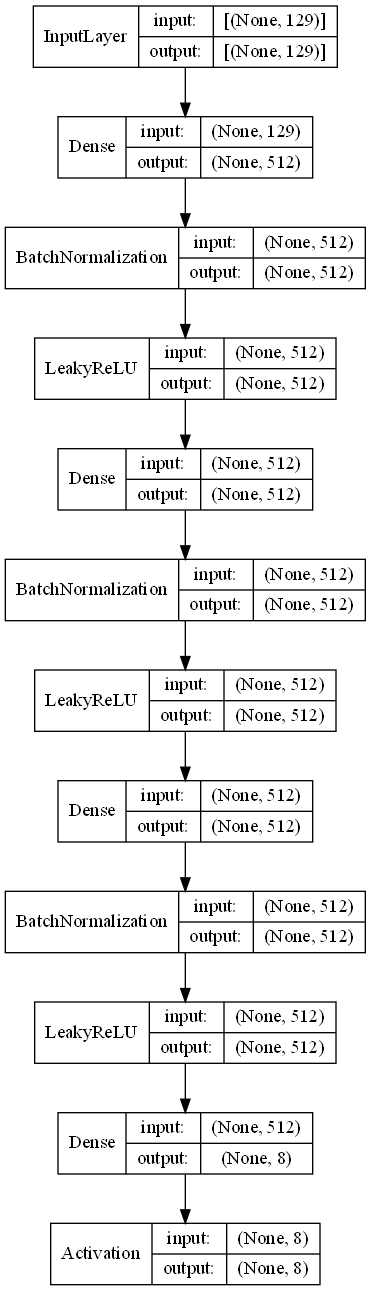

In [15]:
utils.plot_model(
    cgan.generator, show_shapes=True, show_layer_names=False,
    expand_nested=True, rankdir="TB"
)

Next, let's visualize the discriminator:

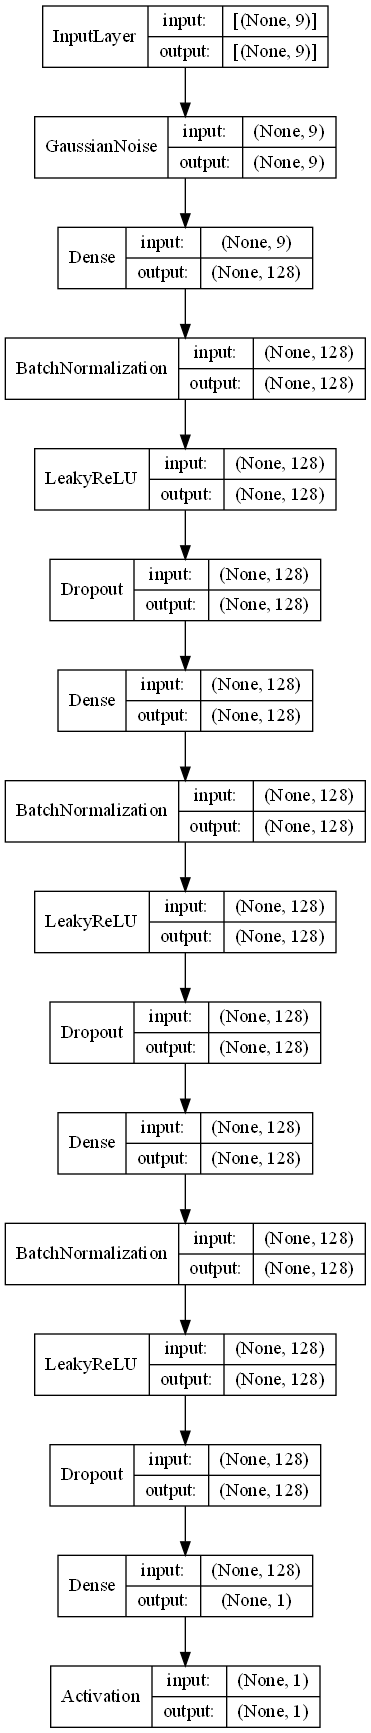

In [16]:
utils.plot_model(
    cgan.discriminator, show_shapes=True, show_layer_names=False,
    expand_nested=True, rankdir="TB"
)

Next, let's train the GAN:

In [17]:
# Train CGAN
history = cgan.fit(
    diabetes_X, diabetes_y, epochs=DIABETES_NUM_EPOCHS, shuffle=True,
    batch_size=BATCH_SIZE
)

Epoch 1/1200
24/24 [==============================] - 2s 6ms/step - g_loss: 0.6935 - d_loss: 0.6928 - d_real_acc: 0.8034 - d_fake_acc: 0.8680
Epoch 2/1200
24/24 [==============================] - 0s 6ms/step - g_loss: 0.6949 - d_loss: 0.6936 - d_real_acc: 0.1999 - d_fake_acc: 0.7728
Epoch 3/1200
24/24 [==============================] - 0s 6ms/step - g_loss: 0.7000 - d_loss: 0.6921 - d_real_acc: 0.0057 - d_fake_acc: 0.9612
Epoch 4/1200
24/24 [==============================] - 0s 5ms/step - g_loss: 0.6925 - d_loss: 0.6928 - d_real_acc: 0.7651 - d_fake_acc: 0.2626
Epoch 5/1200
24/24 [==============================] - 0s 5ms/step - g_loss: 0.6960 - d_loss: 0.6945 - d_real_acc: 0.1860 - d_fake_acc: 0.5310
Epoch 6/1200
24/24 [==============================] - 0s 6ms/step - g_loss: 0.7021 - d_loss: 0.6907 - d_real_acc: 0.2146 - d_fake_acc: 0.9916
Epoch 7/1200
24/24 [==============================] - 0s 6ms/step - g_loss: 0.6545 - d_loss: 0.7064 - d_real_acc: 0.8563 - d_fake_acc: 0.0000e+00
Ep

Next, let's plot training metrics:

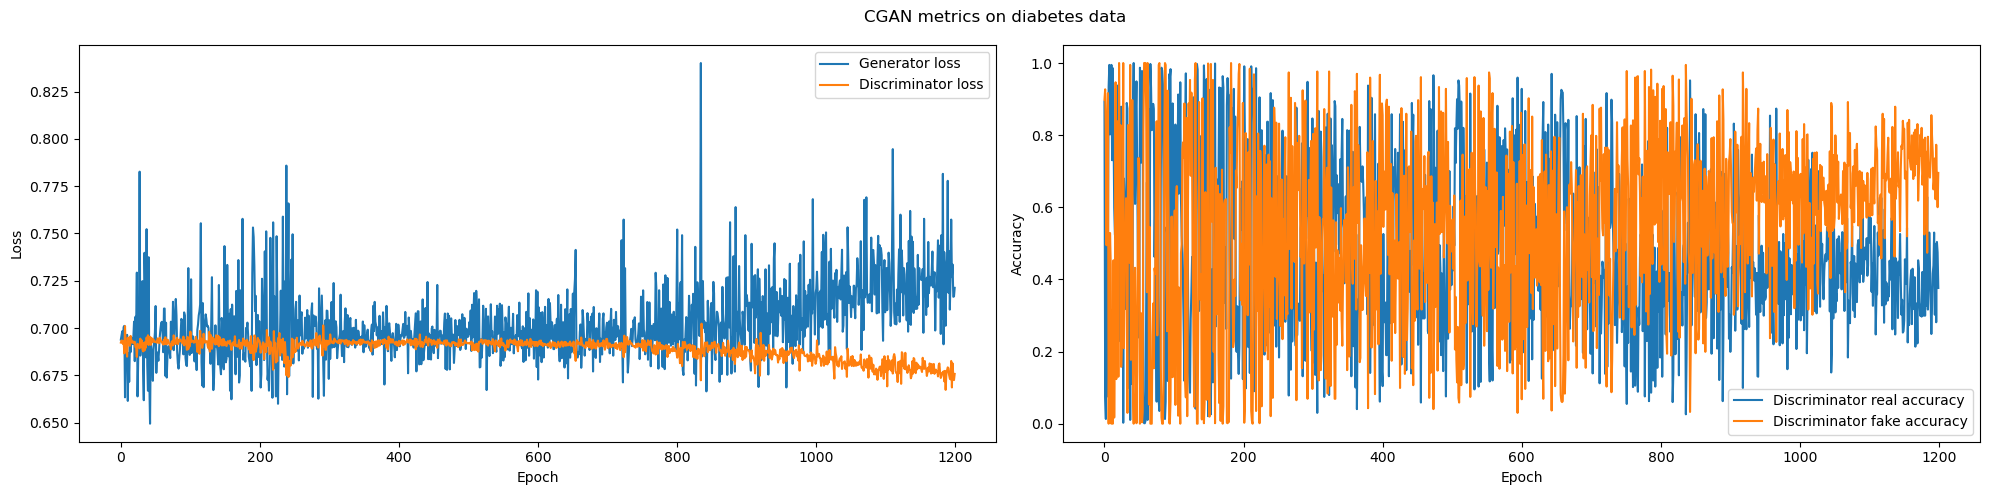

In [18]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_real_acc"], label="Discriminator real accuracy")
ax[1].plot(history.history["d_fake_acc"], label="Discriminator fake accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on diabetes data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [19]:
# Define number of samples to generate
num_samples = diabetes_X.shape[0]

# Sample random points in the latent space for the generator
# and concatenate the labels.
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_labels = tf.concat([random_latent_vectors, diabetes_y], axis=1)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_labels)
fake_records_and_labels = tf.concat([fake_records, diabetes_y], axis=1)

# Get discriminator predictions for fake and real dataset
d_fake_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_labels),
    columns=["probability"]
)
d_real_predictions = pd.DataFrame(
    cgan.discriminator.predict(clean_diabetes_df), columns=["probability"]
)

# Create a fake data frame
fake_clean_diabetes_df = pd.DataFrame(
    fake_records_and_labels.numpy(), columns=clean_diabetes_df.columns
)

# Inverse preprocess
fake_diabetes_df = inverse_pre_process_data(
    fake_clean_diabetes_df, diabetes_num_cols, diabetes_cat_cols,
    diabetes_l_encoder, diabetes_n_scalar, diabetes_c_encoder
)

# Sort fake data frame columns same as regular data frame columns
fake_diabetes_df = fake_diabetes_df.reindex(diabetes_df.columns, axis=1)

Next, let's plot the probability to be real for the generated samples:

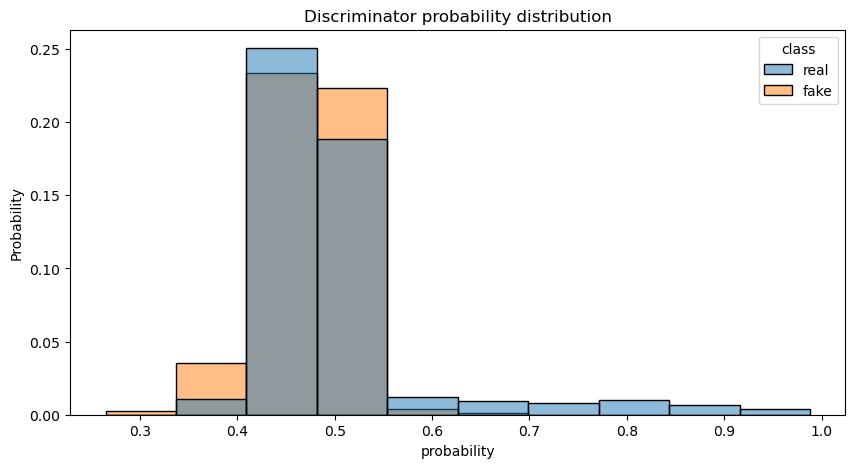

In [20]:
# Add class to data frame for concat
d_real_predictions["class"] = "real"
d_fake_predictions["class"] = "fake"

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot probability
sns.histplot(
    pd.concat([d_real_predictions, d_fake_predictions], ignore_index=True),
    x="probability", hue="class", bins=10, stat="probability", ax=ax
)

# Show plot
plt.title("Discriminator probability distribution")
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [21]:
# Get records that fooled the discriminator
fooled = fake_diabetes_df[d_fake_predictions["probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 42


preg        plas       pres       skin       insu       mass  \
28   0.467070   62.516998  69.791580  25.083942   3.188053  32.834141   
31   0.289234   80.954025  80.417511  24.245792  11.989375  35.539864   
34   0.840393   67.750168  58.226730  18.566761   8.766100  26.092045   
69   2.108303   74.819183   0.974388   0.044224   0.013766  16.719324   
80   5.418090  103.439896  78.136711   0.000000   0.000000  22.659266   
99   3.694934  152.995834   0.000167   0.000531   0.000000  30.123156   
111  2.055166  130.138260  85.832443   0.000000   0.000000  25.763359   
119  0.056038   53.324032  62.070263  21.344994  25.809223  31.995808   
126  0.202205   58.161591  68.528221  27.098307  19.958298  36.878944   
134  0.316175   60.767830  73.049904  31.156050  14.658954  39.951027   

         pedi        age            class  
28   0.863031  27.304157  tested_negative  
31   0.992346  30.573620  tested_positive  
34   0.584342  24.355286  tested_negative  
69   0.119461  21.154465  tested_negative  
80   0.514277  69.465408  tested_negative  
99   0.235413  26.932753  tested_positive  
111  0.581437  58.209488  tested_positive  
119  0.840214  22.393963  tested_negative  
126  0.638671  23.556580  tested_negative  
134  0.695744  24.776836  tested_negative

In [22]:
# Get records that did not fool the discriminator
not_fooled = fake_diabetes_df[d_fake_predictions["probability"] <= 0.5]
# Print number of not fooled records
print(
    (
        f"Number of sample that did not fool the discriminator:"
        f" {not_fooled.shape[0]}"
    )
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 726


preg        plas       pres       skin        insu       mass  \
0   2.749295  106.208733  62.475708  17.651957   39.325359  29.934866   
1   2.306576  102.701515  64.339111  26.941715  120.877106  35.170876   
2   1.039154  100.964317  64.320000  20.222012   95.323662  30.784491   
3   1.459134   74.451736  55.623055  28.026606   40.246330  28.879293   
4   0.926391   79.767273  76.826950  22.369547   16.828386  33.214603   
5   0.460393   65.328377  65.436584  28.949244   17.803438  33.504997   
6  13.311133  117.544350  83.728958  23.357840   27.761549  29.419146   
7  10.246860   79.144524  73.981918  31.314011    7.587933  35.933495   
8   2.557977  178.888962  68.249870  21.933054  157.740692  33.126682   
9   3.205697  153.133118  58.505005  27.169399  111.620110  29.939083   

       pedi        age            class  
0  0.218589  23.806908  tested_positive  
1  0.433919  26.697441  tested_negative  
2  0.535398  28.938505  tested_positive  
3  0.239118  23.732988  tested_negative  
4  0.895167  33.560009  tested_positive  
5  0.528179  22.447119  tested_negative  
6  0.583043  54.204292  tested_positive  
7  0.381676  38.248909  tested_negative  
8  0.578837  31.933979  tested_positive  
9  0.350592  23.764996  tested_positive

Lets evaluate the generated samples using table evaluator:

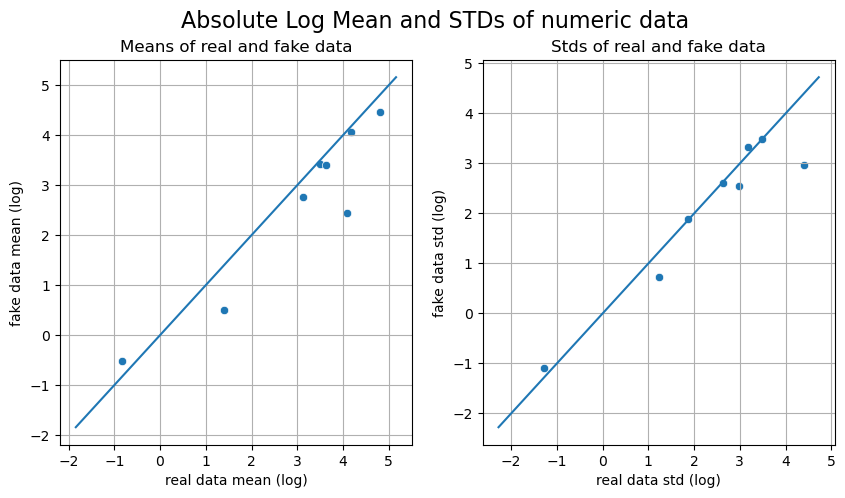

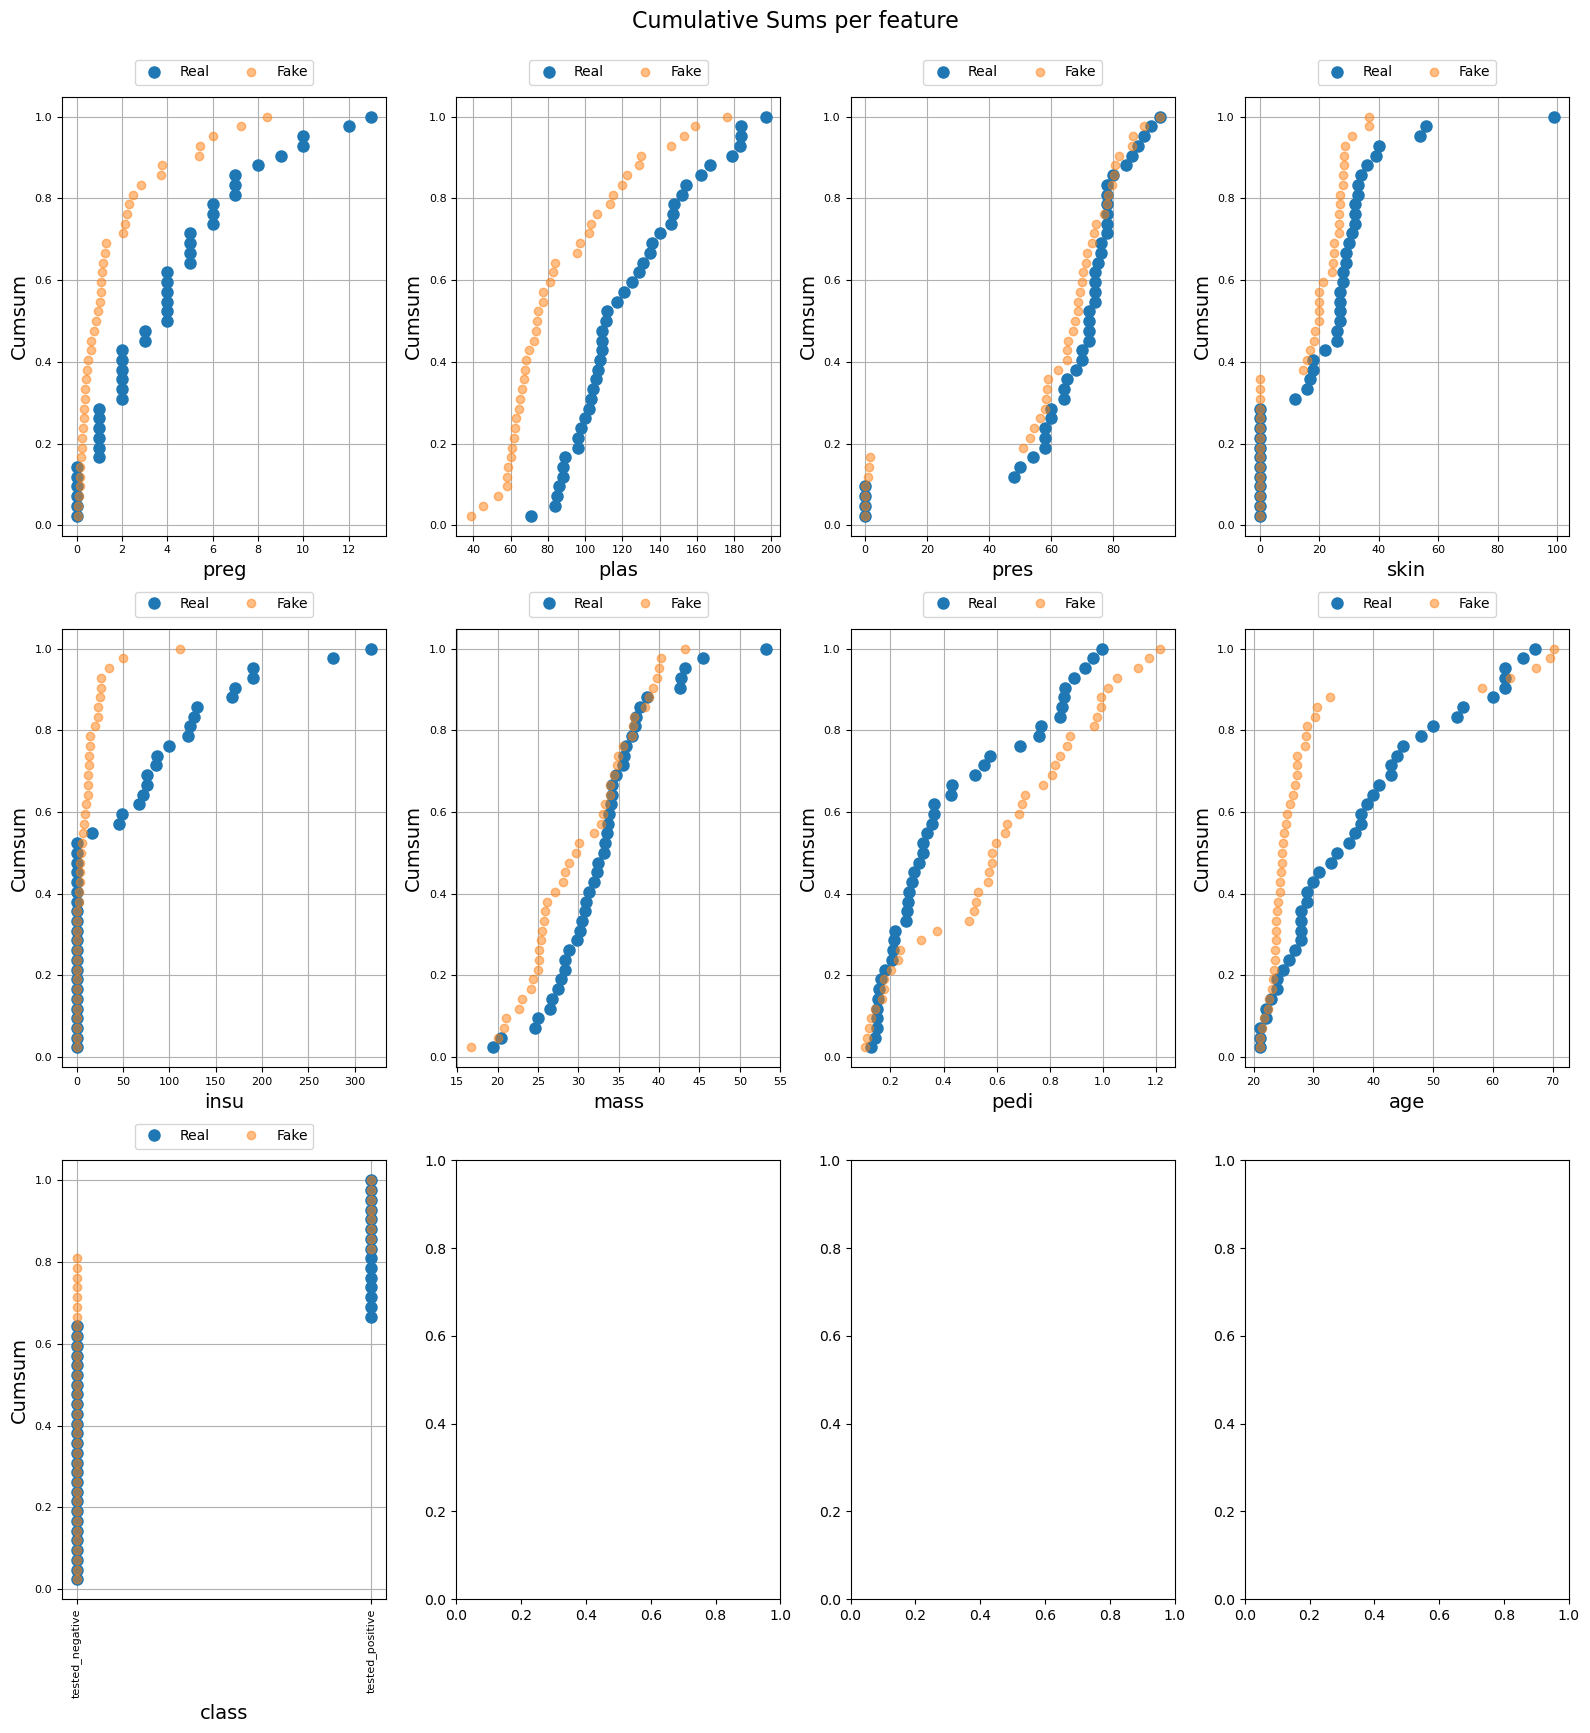

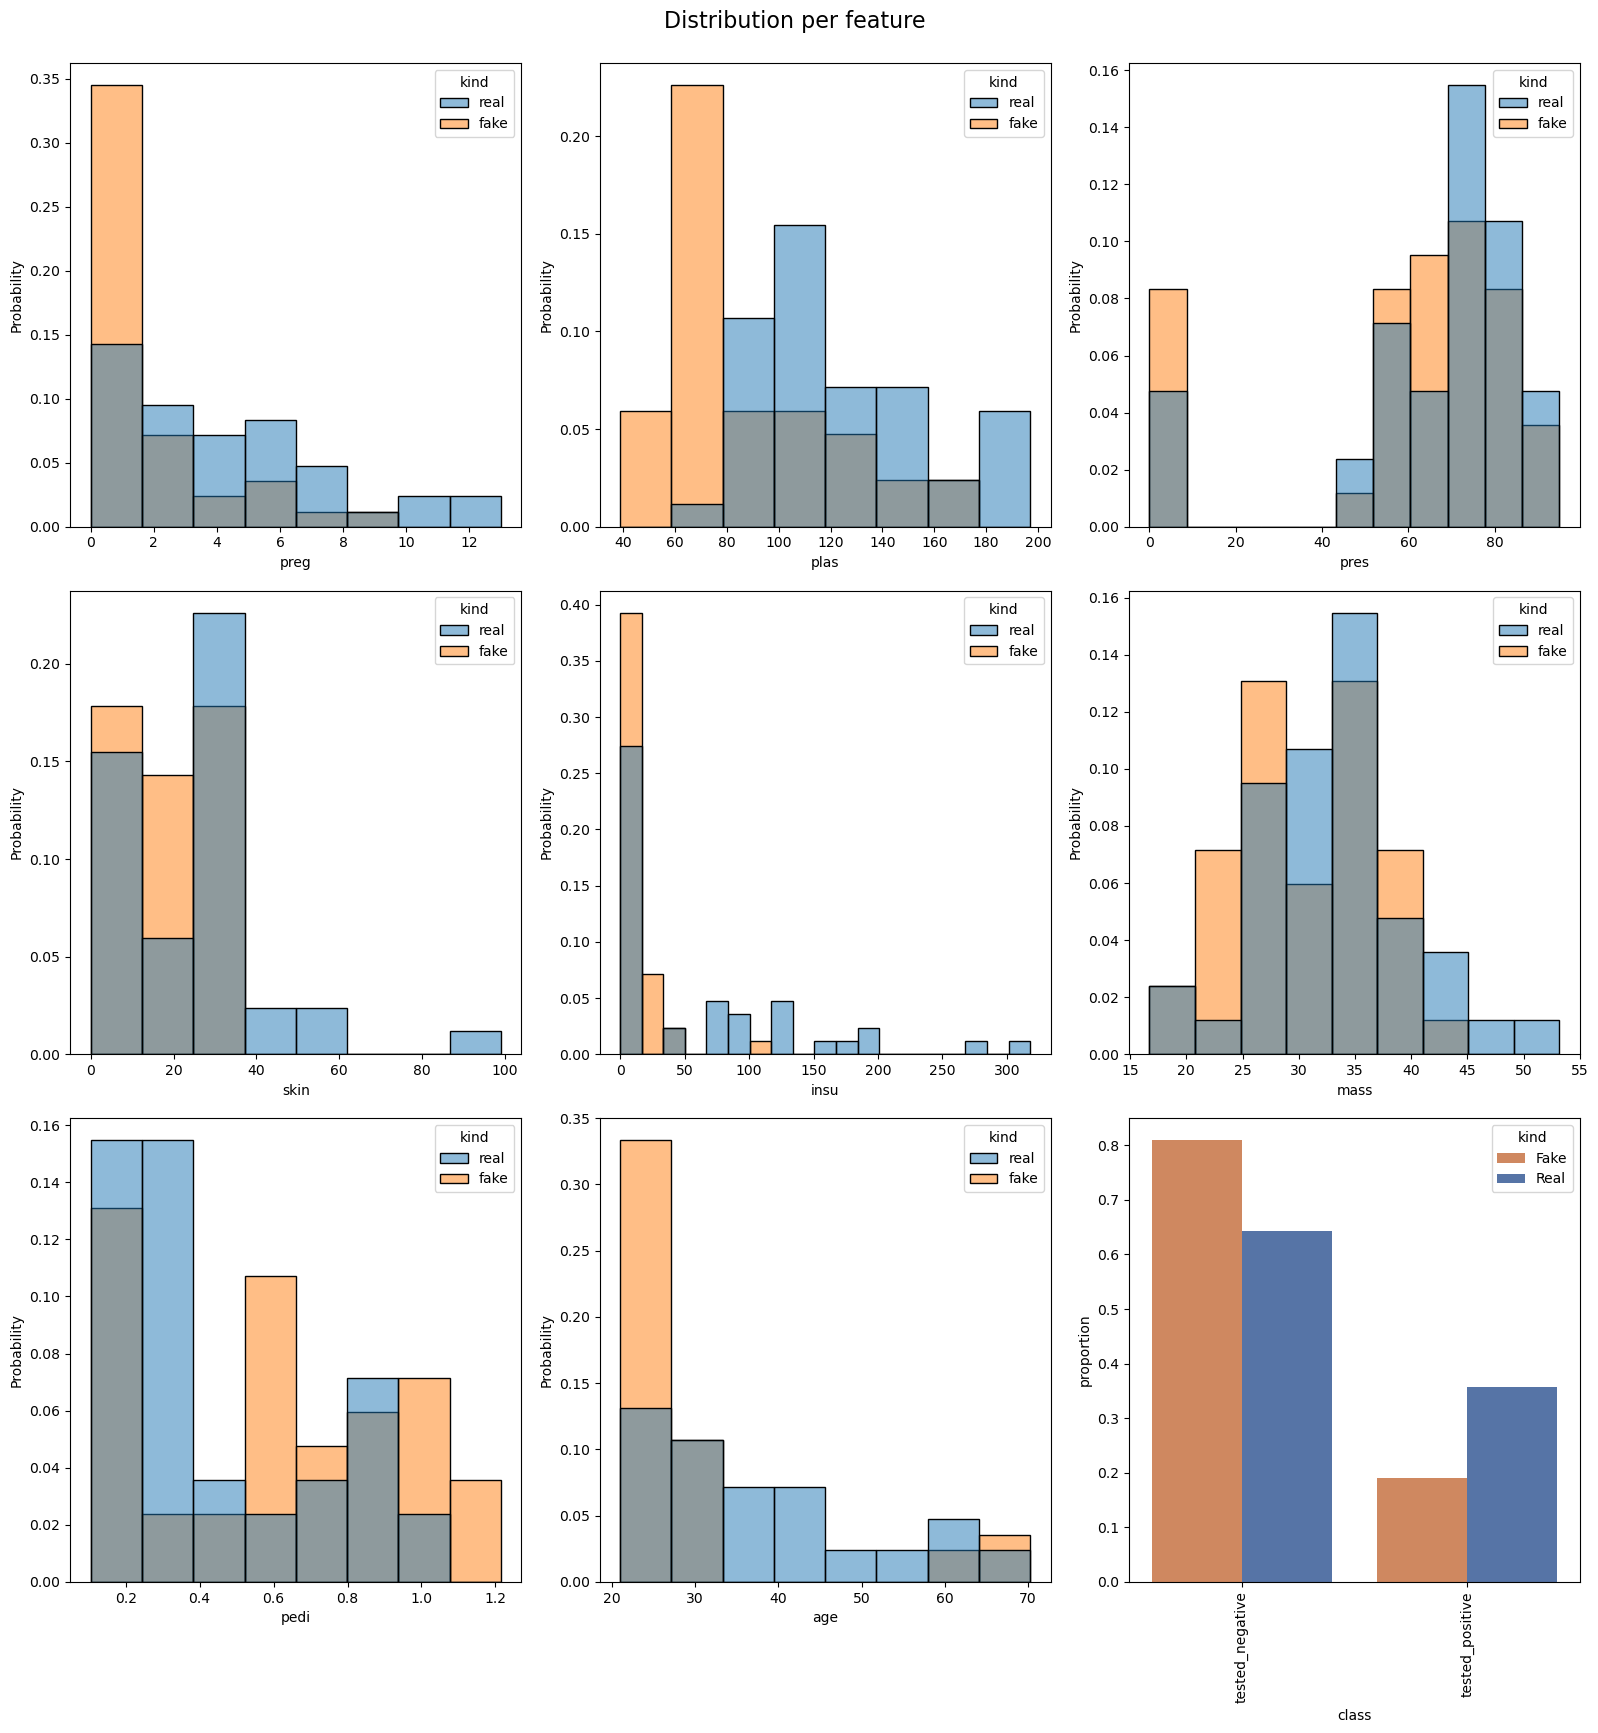

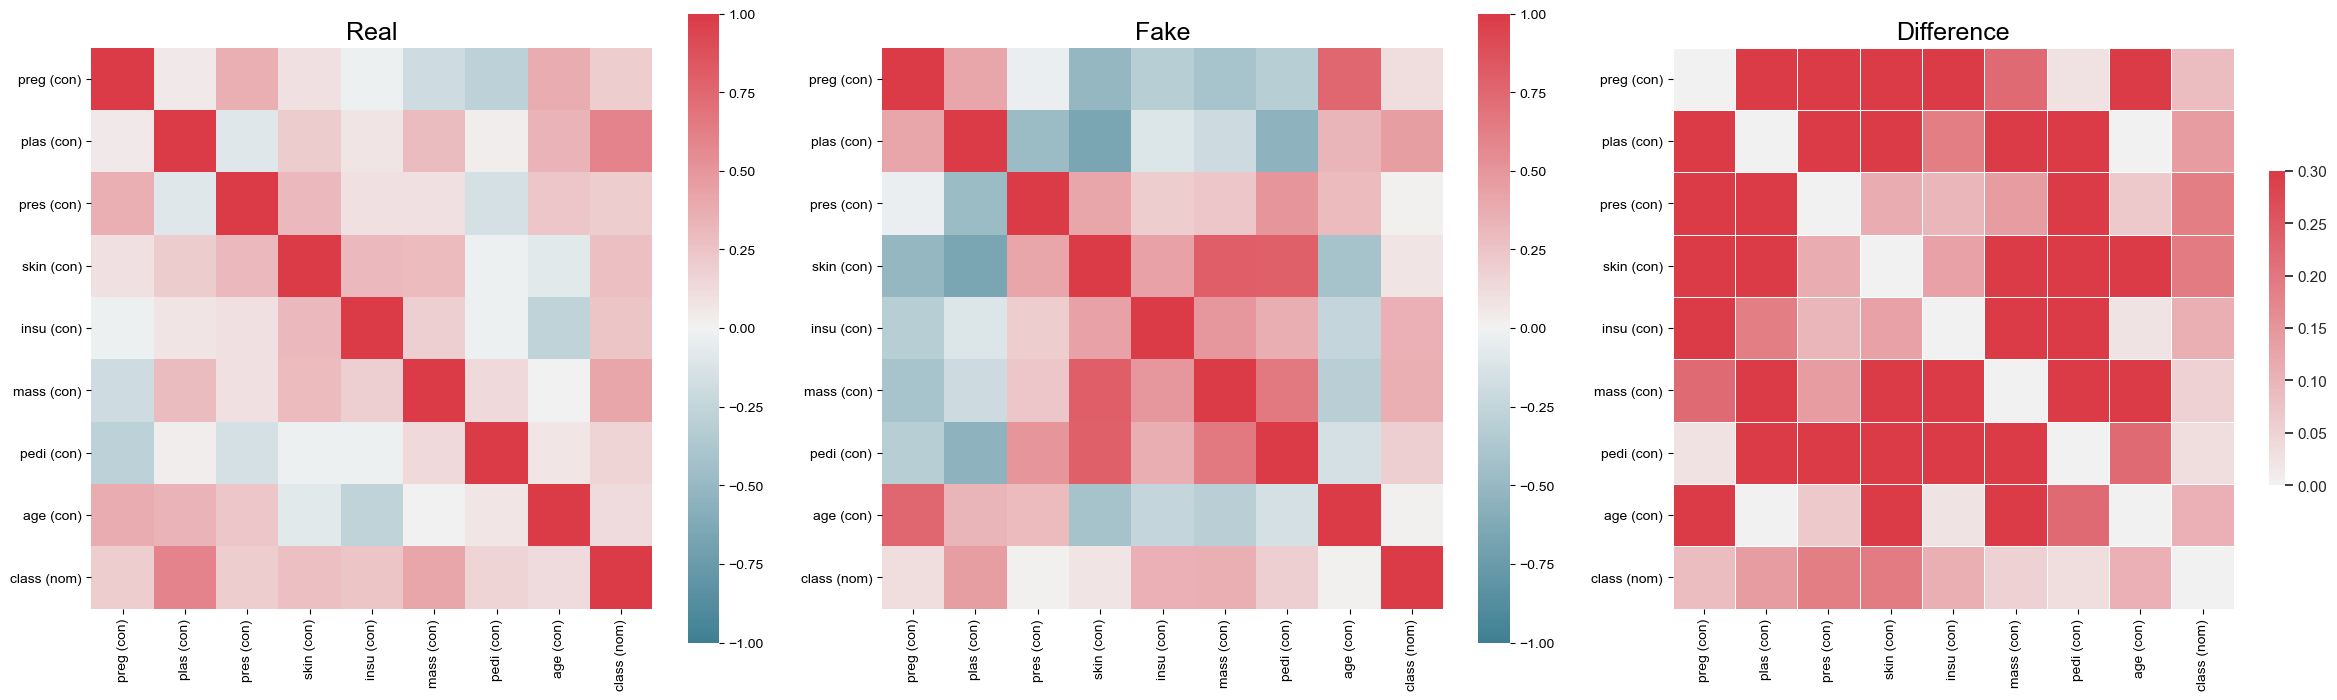

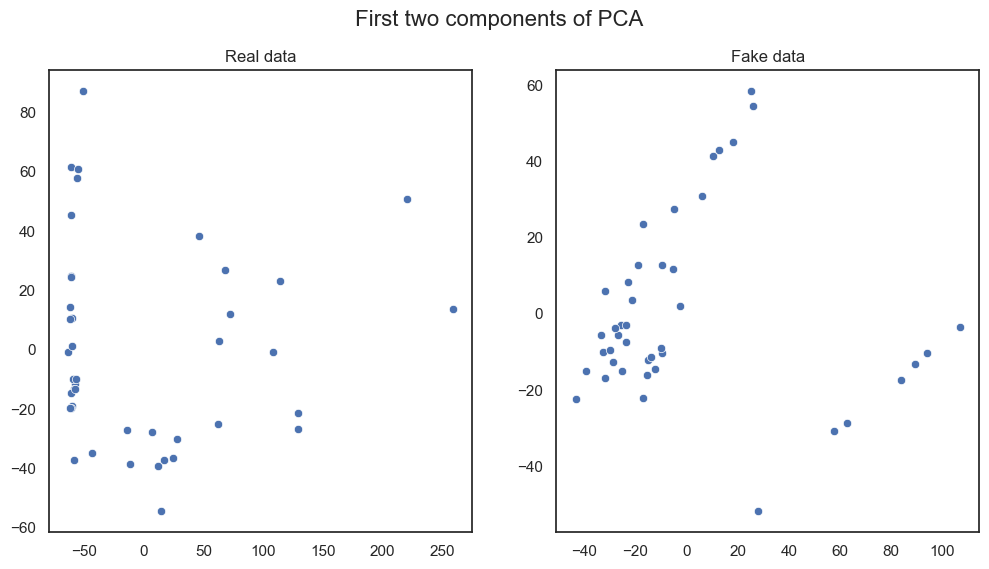


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6667   0.6667              0.6364
DecisionTreeClassifier_real   0.7778   0.5556              0.3846
LogisticRegression_fake       0.6667   0.8889              0.6364
LogisticRegression_real       0.6667   0.5556              0.5000
MLPClassifier_fake            0.5556   0.3333              0.6364
MLPClassifier_real            0.5556   0.5556              0.3846
RandomForestClassifier_fake   0.4444   0.4444              0.3846
RandomForestClassifier_real   0.5556   1.0000              0.3846

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    2.0970
nearest neighbor std                     0.6203

Miscellaneous results:
                                  Result
Column Cor

In [23]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    diabetes_df, fooled.reset_index(drop=True),
    cat_cols=diabetes_cat_cols + ["class"]
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")

##### ***German Credit training & evaluation***

Next, let's create a conditional GAN on the germen credit data:

In [24]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = g_credit_X.shape[-1]
num_class = g_credit_y.shape[-1]

# Create CGAN
gen = make_generator(latent_dim + num_class, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + num_class)
cgan = CGAN(gen, dis, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
)

Next, let's visualize the generator:

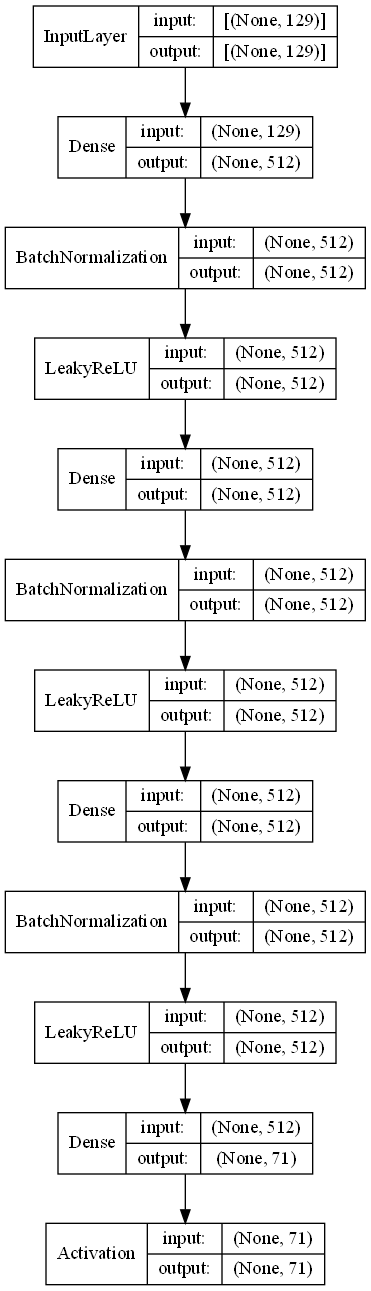

In [25]:
utils.plot_model(
    cgan.generator, show_shapes=True, show_layer_names=False,
    expand_nested=True, rankdir="TB"
)

Next, let's visualize the discriminator:

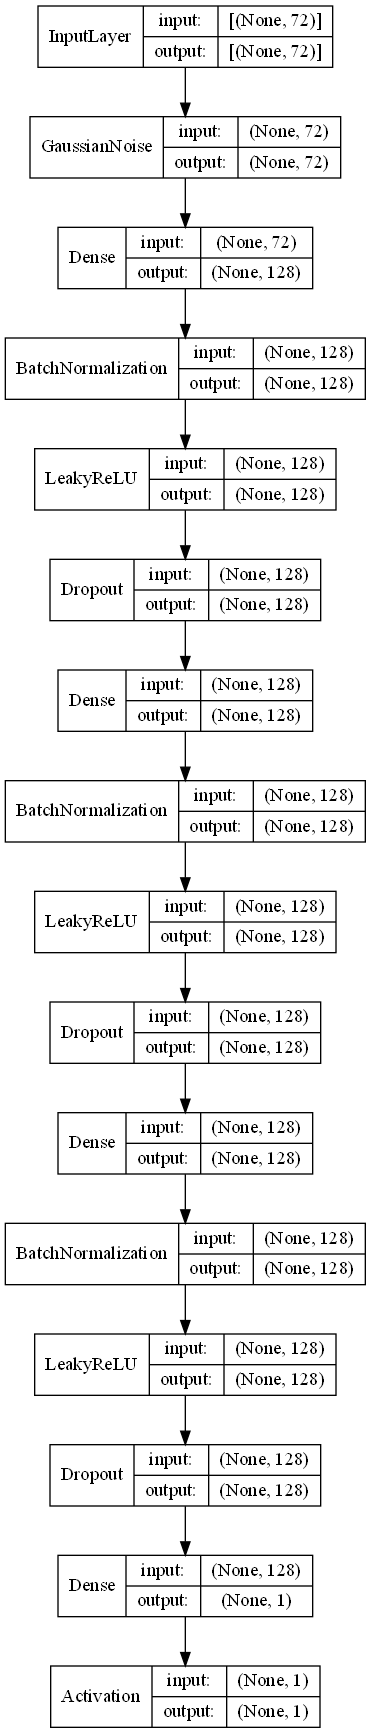

In [26]:
utils.plot_model(
    cgan.discriminator, show_shapes=True, show_layer_names=False,
    expand_nested=True, rankdir="TB"
)

Next, let's train the GAN:

In [27]:
# Train CGAN
history = cgan.fit(
    g_credit_X, g_credit_y, epochs=G_CREDIT_NUM_EPOCHS, shuffle=True,
    batch_size=BATCH_SIZE
)

Epoch 1/200
32/32 [==============================] - 2s 11ms/step - g_loss: 0.6917 - d_loss: 0.6919 - d_real_acc: 0.9053 - d_fake_acc: 0.6964
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.7116 - d_loss: 0.6905 - d_real_acc: 0.0068 - d_fake_acc: 1.0000
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.6944 - d_loss: 0.6853 - d_real_acc: 0.9842 - d_fake_acc: 0.6918
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - g_loss: 0.7007 - d_loss: 0.6877 - d_real_acc: 0.6596 - d_fake_acc: 0.5582
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.6839 - d_loss: 0.6934 - d_real_acc: 0.9456 - d_fake_acc: 0.1520
Epoch 6/200
32/32 [==============================] - 0s 6ms/step - g_loss: 0.7071 - d_loss: 0.6925 - d_real_acc: 0.1459 - d_fake_acc: 0.9578
Epoch 7/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.6751 - d_loss: 0.6979 - d_real_acc: 0.8590 - d_fake_acc: 0.0795
Epoch 8/200


Next, let's plot training metrics:

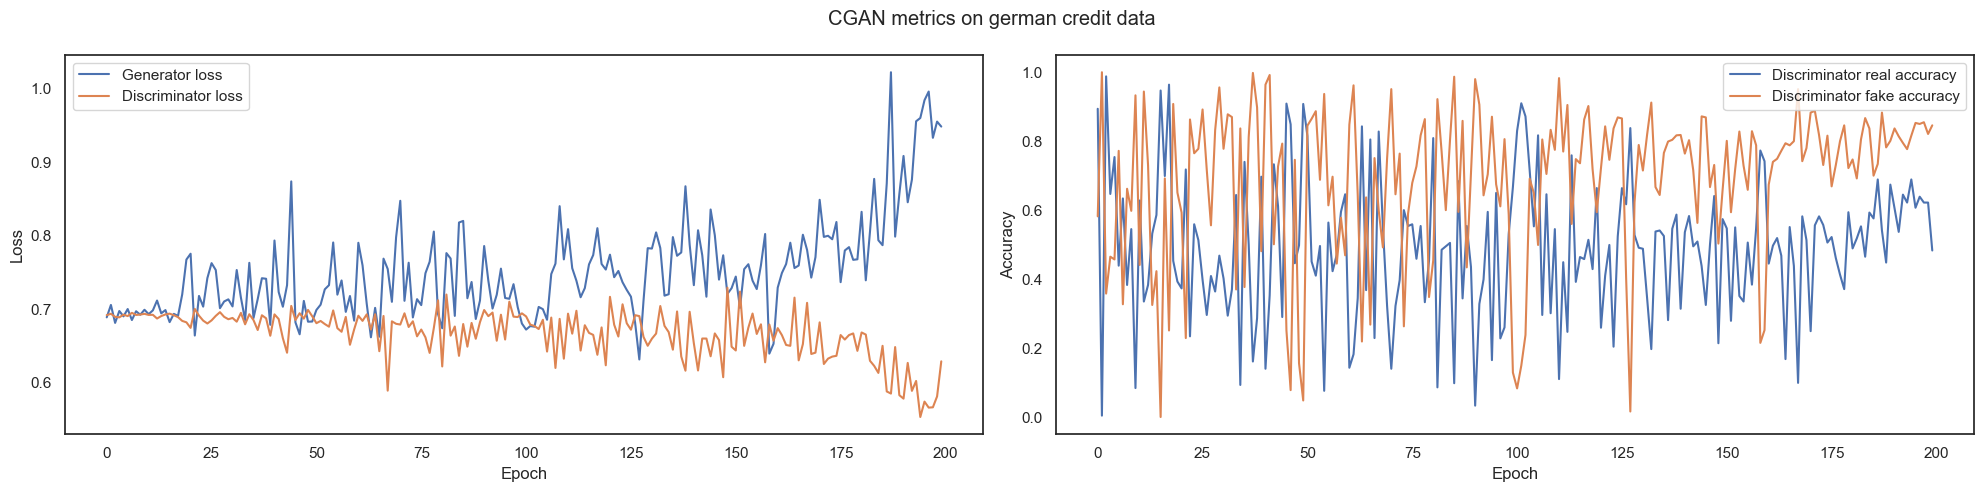

In [28]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_real_acc"], label="Discriminator real accuracy")
ax[1].plot(history.history["d_fake_acc"], label="Discriminator fake accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on german credit data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [29]:
# Define number of samples to generate
num_samples = g_credit_X.shape[0]

# Sample random points in the latent space for the generator
# and concatenate the labels.
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_labels = tf.concat([random_latent_vectors, g_credit_y], axis=1)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_labels)
fake_records_and_labels = tf.concat([fake_records, g_credit_y], axis=1)

# Get discriminator predictions for fake and real dataset
d_fake_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_labels),
    columns=["probability"]
)
d_real_predictions = pd.DataFrame(
    cgan.discriminator.predict(clean_g_credit_df), columns=["probability"]
)

# Create a fake data frame
fake_clean_g_credit_df = pd.DataFrame(
    fake_records_and_labels.numpy(), columns=clean_g_credit_df.columns
)

# Inverse preprocess
fake_g_credit_df = inverse_pre_process_data(
    fake_clean_g_credit_df, g_credit_num_cols, g_credit_cat_cols,
    g_credit_l_encoder, g_credit_n_scalar, g_credit_c_encoder
)

# Sort fake data frame columns same as regular data frame columns
fake_g_credit_df = fake_g_credit_df.reindex(g_credit_df.columns, axis=1)

Next, let's plot the probability to be real for the generated samples:

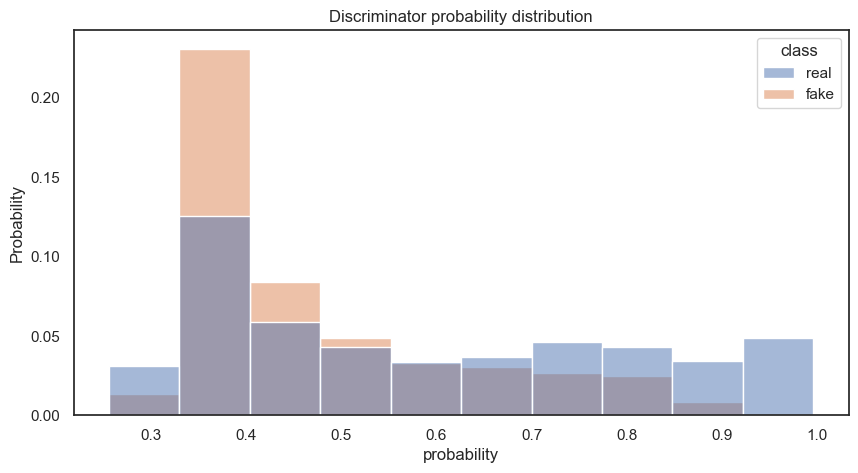

In [30]:
# Add class to data frame for concat
d_real_predictions["class"] = "real"
d_fake_predictions["class"] = "fake"

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot probability
sns.histplot(
    pd.concat([d_real_predictions, d_fake_predictions], ignore_index=True),
    x="probability", hue="class", bins=10, stat="probability", ax=ax
)

# Show plot
plt.title("Discriminator probability distribution")
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [31]:
# Get records that fooled the discriminator
fooled = fake_g_credit_df[d_fake_predictions["probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 317


1       2    3    4          5    6    7      8    9    10  ...    12  \
0   A12 12.3181  A32  A49 2,138.7583  A61  A72 2.0000  A93  A101  ...  A121   
1   A12 23.9420  A32  A49 2,974.2639  A61  A72 3.0000  A94  A101  ...  A124   
3   A14 15.6978  A34  A42 1,860.0465  A61  A75 4.0000  A93  A101  ...  A123   
12  A14 23.2432  A32  A49 3,756.1301  A62  A73 4.0000  A93  A101  ...  A121   
13  A12 20.4912  A32  A49 1,436.8519  A61  A72 2.0000  A93  A101  ...  A124   
20  A14 11.3845  A34  A42   791.4850  A61  A73 4.0000  A93  A101  ...  A123   
23  A14 11.5547  A34  A42   742.6724  A61  A75 4.0000  A93  A101  ...  A121   
25  A12 11.4434  A32  A43 4,454.6025  A65  A75 2.0000  A91  A101  ...  A124   
26  A12 18.9103  A32  A41 2,808.5757  A65  A75 4.0000  A93  A101  ...  A124   
36  A14 19.2543  A32  A43 3,000.6758  A65  A75 4.0000  A93  A101  ...  A124   

        13    14    15     16    17     18    19    20 class  
0  32.7501  A143  A152 1.0000  A173 1.0000  A192  A201     1  
1  36.1297  A143  A152 1.0000  A173 1.0000  A192  A201     2  
3  30.7811  A143  A152 2.0000  A173 2.0000  A191  A201     1  
12 33.1127  A143  A152 1.0000  A173 1.0000  A192  A201     1  
13 27.8001  A143  A152 1.0000  A173 1.0000  A192  A201     2  
20 24.3747  A143  A152 2.0000  A173 1.0000  A191  A201     1  
23 30.9703  A143  A152 2.0000  A173 1.0000  A191  A201     1  
25 49.8635  A143  A153 1.0000  A174 1.0000  A192  A201     1  
26 36.5761  A143  A151 1.0000  A173 1.0000  A192  A201     1  
36 32.6560  A143  A152 1.0000  A173 1.0000  A192  A201     1  

[10 rows x 21 columns]

In [32]:
# Get records that did not fool the discriminator
not_fooled = fake_g_credit_df[d_fake_predictions["probability"] <= 0.5]
# Print number of not fooled records
print(
    (
        f"Number of sample that did not fool the discriminator:"
        f" {not_fooled.shape[0]}"
    )
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 683


1       2    3    4          5    6    7      8    9    10  ...    12  \
2   A12 17.8272  A34  A43 2,957.6274  A61  A75 2.0000  A93  A101  ...  A121   
4   A14  7.4975  A34  A42 1,014.8570  A61  A71 4.0000  A93  A101  ...  A123   
5   A14 22.2235  A32  A49 2,019.1740  A61  A73 4.0000  A93  A101  ...  A123   
6   A12 20.7837  A32  A49 1,520.2126  A61  A73 3.0000  A94  A101  ...  A124   
7   A14 11.0457  A34  A40 3,062.4209  A61  A75 2.0000  A93  A101  ...  A121   
8   A14 23.9226  A32  A43 4,085.5029  A65  A75 4.0000  A93  A101  ...  A123   
9   A12 31.0905  A32  A49 2,060.2715  A61  A73 4.0000  A93  A101  ...  A123   
10  A11 22.0236  A32  A42 4,502.1270  A61  A72 4.0000  A93  A101  ...  A124   
11  A11 24.4131  A32  A43 4,990.0542  A61  A72 4.0000  A93  A101  ...  A124   
14  A12 10.4194  A32  A40 1,479.2245  A61  A72 2.0000  A92  A101  ...  A121   

        13    14    15     16    17     18    19    20 class  
2  41.3774  A143  A152 1.0000  A173 1.0000  A191  A201     1  
4  26.2912  A143  A152 2.0000  A173 1.0000  A191  A201     2  
5  26.8397  A143  A152 1.0000  A173 1.0000  A191  A201     1  
6  29.6804  A143  A152 1.0000  A173 1.0000  A192  A201     1  
7  45.0632  A143  A151 1.0000  A173 1.0000  A191  A201     1  
8  34.5515  A143  A152 2.0000  A173 1.0000  A192  A201     1  
9  25.3709  A143  A152 1.0000  A173 1.0000  A191  A201     2  
10 35.6831  A142  A153 1.0000  A173 2.0000  A192  A201     2  
11 39.0658  A143  A153 1.0000  A173 2.0000  A191  A201     2  
14 34.4801  A143  A151 1.0000  A173 1.0000  A191  A201     1  

[10 rows x 21 columns]

Lets evaluate the generated samples using table evaluator:

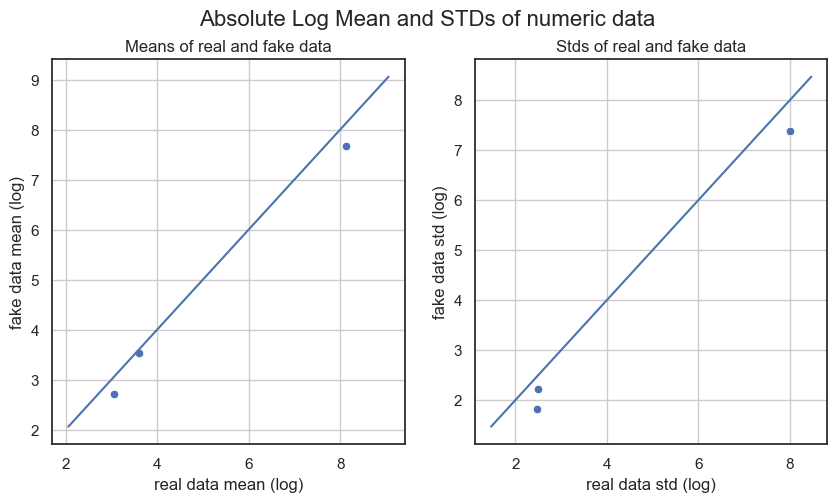

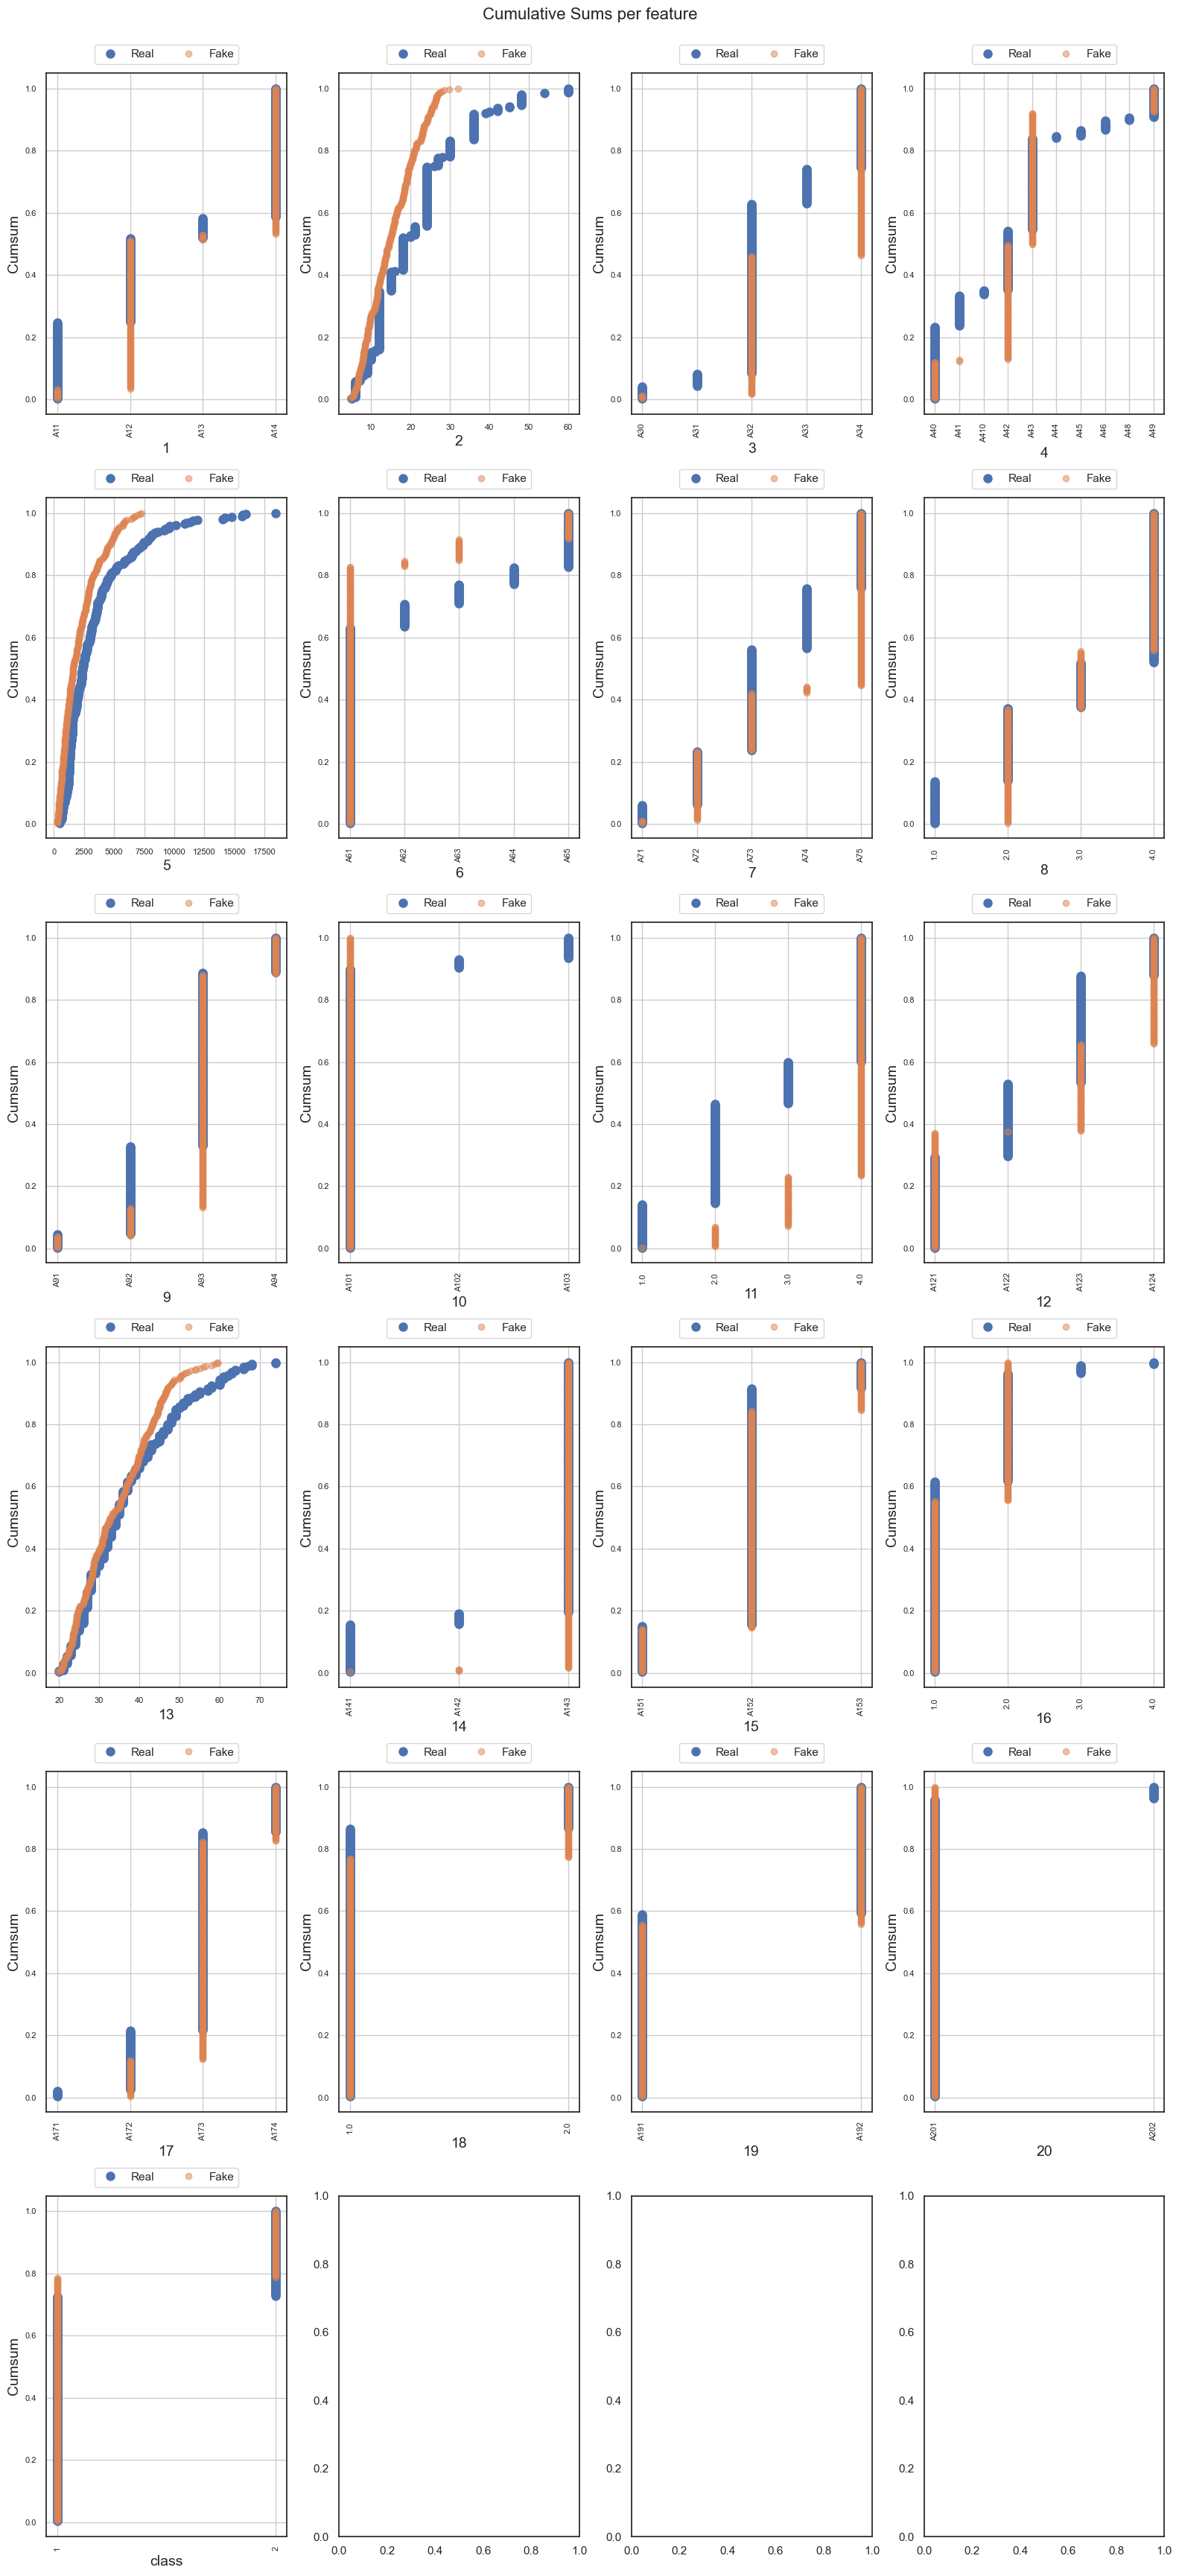

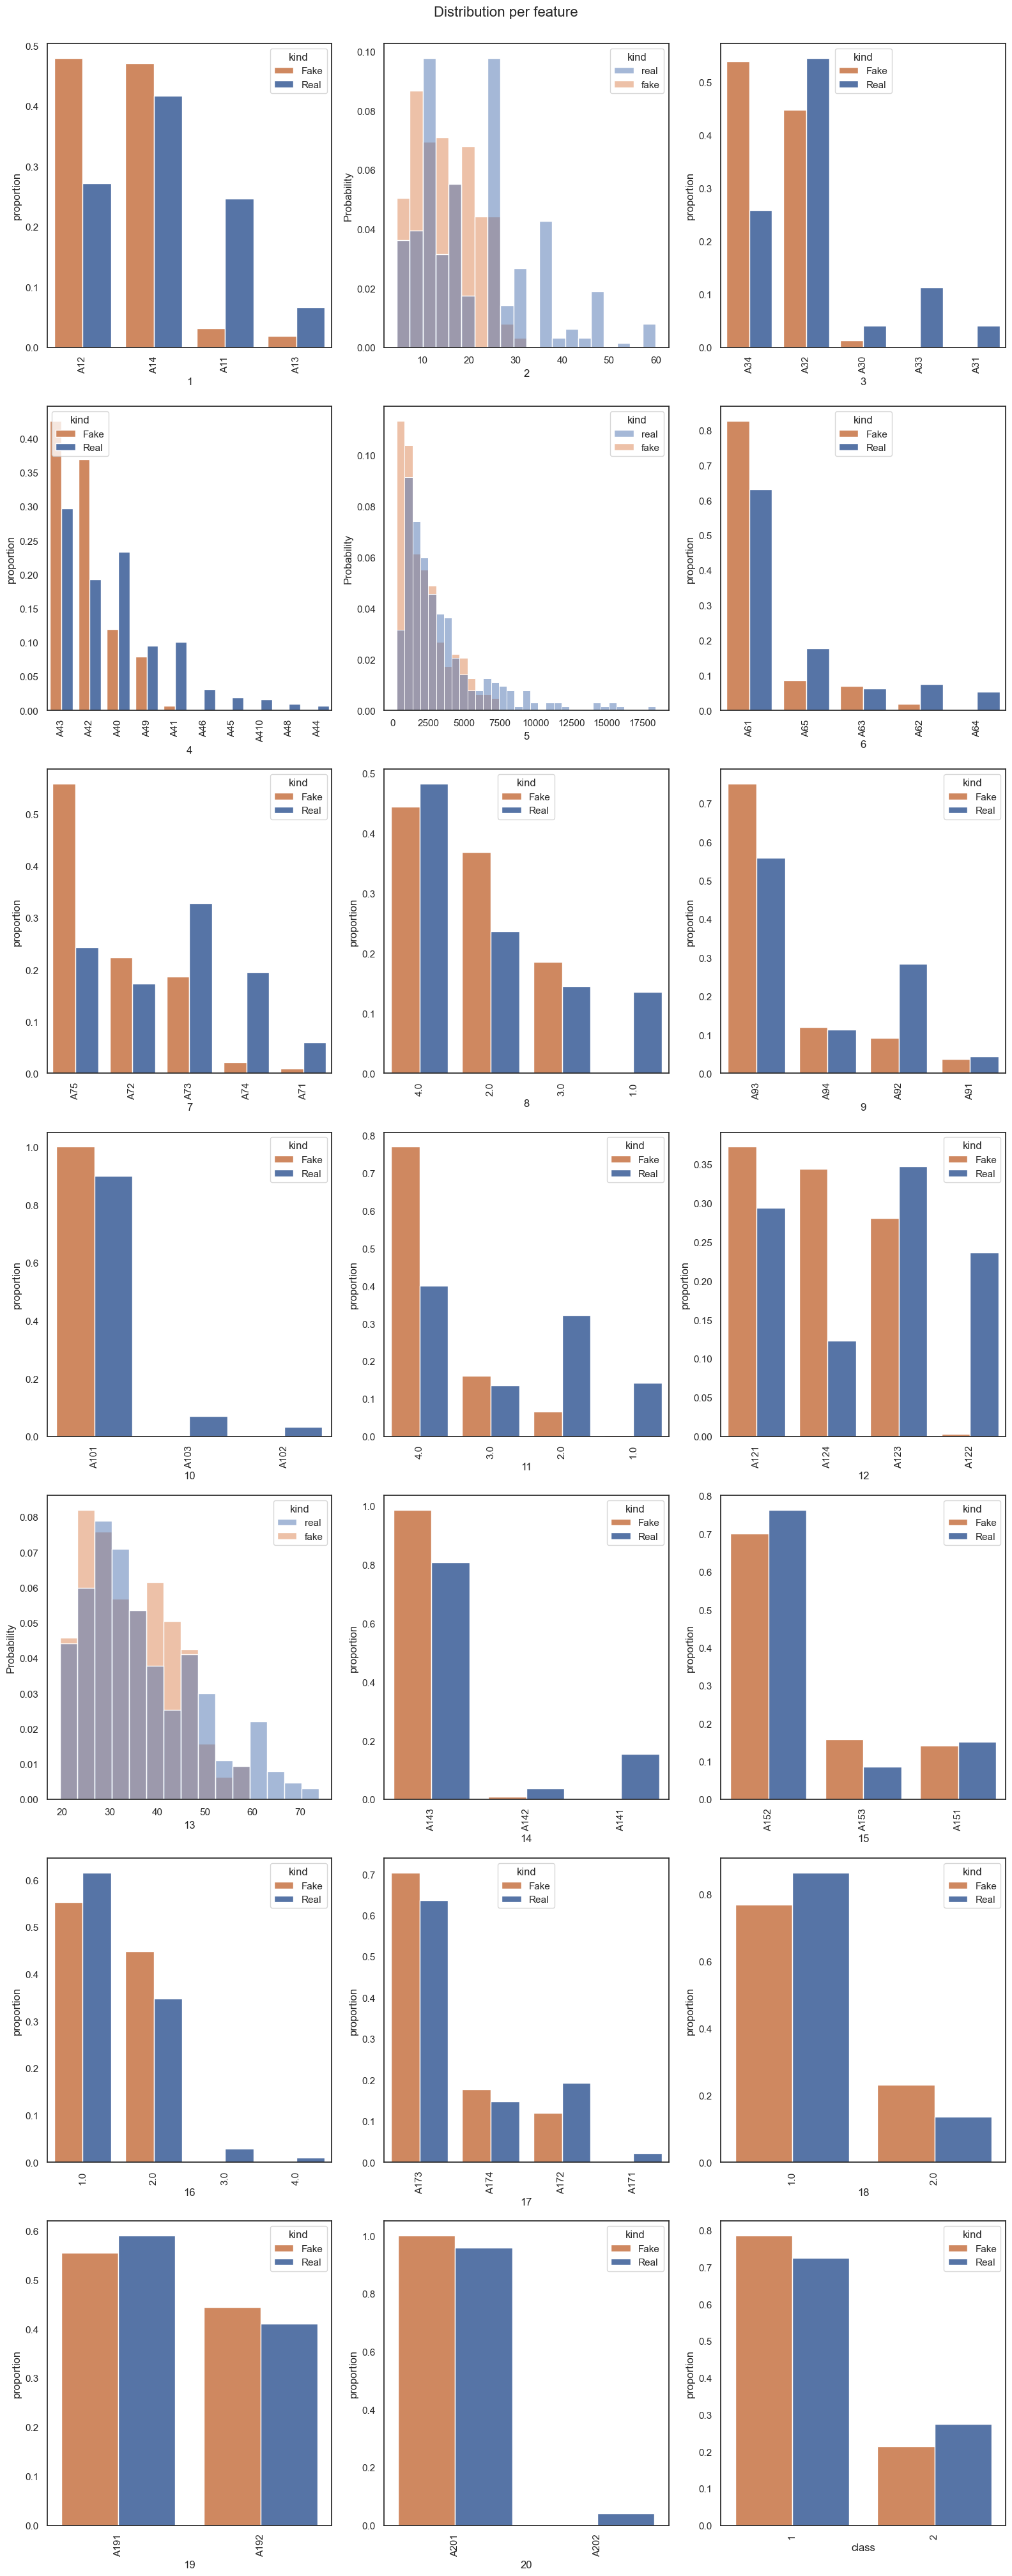

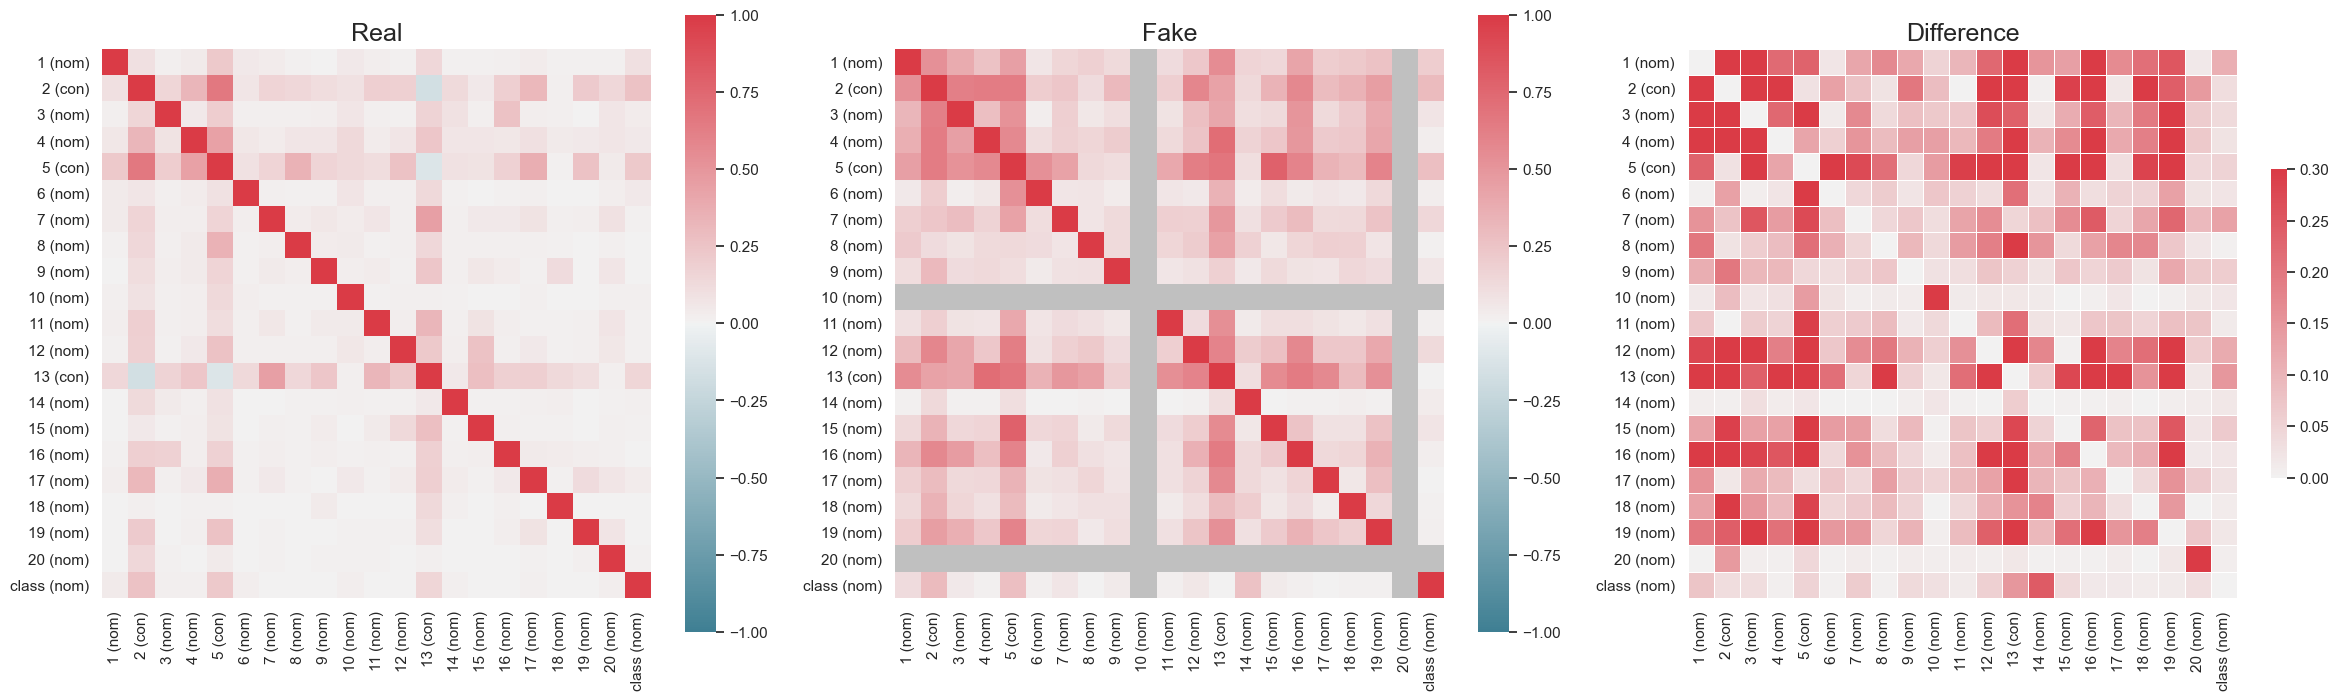

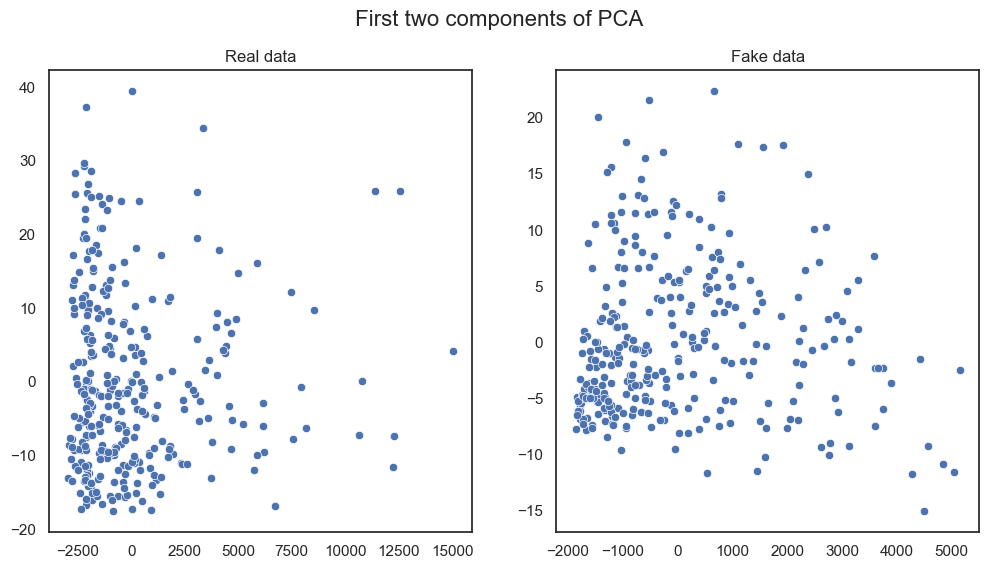


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7500   0.8438              0.5238
DecisionTreeClassifier_real   0.6562   0.4062              0.3333
LogisticRegression_fake       0.7500   0.8594              0.7067
LogisticRegression_real       0.7656   0.5938              0.4713
MLPClassifier_fake            0.7500   0.8125              0.6842
MLPClassifier_real            0.7656   0.5000              0.3474
RandomForestClassifier_fake   0.7969   0.8438              0.7534
RandomForestClassifier_real   0.7031   0.7188              0.6623

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    3.7493
nearest neighbor std                     0.3973

Miscellaneous results:
                                  Result
Column Cor

In [33]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    g_credit_df, fooled.reset_index(drop=True),
    cat_cols=g_credit_cat_cols + ["class"]
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")

### ***Part 2 – Generative Adversarial Networks with a twist***

In this part we will implement a simple GAN model for tabular data.
Let's start with implementing a GAN:

##### ***CGAN implementation***

In [34]:
def make_generator(latent_dim: int, layer_dim: int, data_dim: int) -> Model:
  """Method to create generator for gan.

  Args:
    latent_dim (int): The latent dimension to create noise.
    layer_dim (int): The layer dimension to create generator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Generator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=latent_dim),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(data_dim,kernel_initializer=WEIGHT_INIT),
          layers.Activation(activations.tanh)
      ], name="generator"
  )


def make_discriminator(layer_dim: int, data_dim: int) -> Model:
  """Method to create discriminator for gan.

  Args:
    layer_dim (int): The layer dimension to create discriminator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Discriminator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=data_dim),
          layers.GaussianNoise(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(1, kernel_initializer=WEIGHT_INIT),
          layers.Activation(activations.sigmoid)
      ], name="discriminator"
  )


class CGAN(Model):
  """Conditional GAN class.

  """

  def __init__(
      self, generator: Model, discriminator: Model, black_box: Any,
      latent_dim: int
  ):
    """Initializer method.

    Args:
      generator (Model): Generator model for CGAN.
      discriminator (Model): Discriminator model for CGAN.
      latent_dim (int): The latent dimension to create noise.

    """
    super(CGAN, self).__init__()

    # Save GAN parameters
    self.latent_dim = latent_dim
    self.generator = generator
    self.discriminator = discriminator
    self.black_box = black_box

    # Create loss to track generator and discriminator for every batch
    self.g_loss_tracker = metrics.Mean(name="generator_loss")
    self.d_loss_tracker = metrics.Mean(name="discriminator_loss")

    # Create metrics to track discriminator for every batch
    self.c_bce_metric = metrics.BinaryAccuracy()
    self.y_bce_metric = metrics.BinaryAccuracy()

  @property
  def metrics(self) -> Tuple[metrics.Mean, ...]:
    """Method to get metrics property.

    Returns:
        Tuple[metrics.Mean, ...]: GAN metrics.

    """
    return (
        self.g_loss_tracker, self.d_loss_tracker, self.c_bce_metric,
        self.y_bce_metric
    )

  def compile(
      self, d_optimizer: optimizers.Optimizer,
      g_optimizer: optimizers.Optimizer, loss_fn: losses.Loss
  ):
    """Method to Configures the model for training.

    Args:
        d_optimizer (optimizers.Optimizer): Discriminator optimizer.
        g_optimizer (optimizers.Optimizer): Generator optimizer.
        loss_fn (losses.Loss): GAN loss function.

    """
    super(CGAN, self).compile(run_eagerly=True)
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(
      self, confidence_data: Tuple[tf.Tensor, tf.Tensor]
  ) -> Dict[str, float]:
    """Method to apply Training process on every batch of data. 

    Args:
        data (Tuple[tf.Tensor, tf.Tensor]): Batch of data.

    Returns:
        Dict[str: float]: Metrics values of training step.

    """
    # Unpack confidence score
    c, c = confidence_data

    # Get data size
    data_size = tf.shape(c)[0]

    # Sample random points in the latent space for the generator
    # and concatenate a random confidence score.
    random_latent_vectors = tf.random.normal(shape=(data_size, self.latent_dim))
    random_vector_c = tf.concat([random_latent_vectors, c], axis=1)

    # Train the discriminator and generator
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      # Decode the noise to fake records
      fake_records = self.generator(random_vector_c, training=True)

      # Get classification confidence score
      y = np.expand_dims(
          self.black_box.predict_proba(fake_records.numpy())[:, 1], axis=1
      )

      # concatenate the classification confidence score and random confidence
      # score to fake records
      fake_records_c = tf.concat([fake_records, c], axis=1)
      fake_records_y = tf.concat([fake_records, y], axis=1)

      # Get discriminator prediction
      fake_records_c_predictions = self.discriminator(fake_records_c)
      fake_records_y_predictions = self.discriminator(fake_records_y)

      # Calculate c loss
      d_c_loss = self.loss_fn(
          tf.zeros((data_size, 1)), fake_records_c_predictions
      )

      # Calculate y loss
      d_y_loss = self.loss_fn(
          tf.ones((data_size, 1)), fake_records_y_predictions
      )

      # Calculate discriminator and generator loss
      d_loss = (d_c_loss + d_y_loss) / 2
      g_loss = self.loss_fn(tf.ones((data_size, 1)), fake_records_c_predictions)

    # Update generator and discriminator gradients
    g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
    d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(g_grads, self.generator.trainable_weights)
    )
    self.d_optimizer.apply_gradients(
        zip(d_grads, self.discriminator.trainable_weights)
    )

    # Update metrics
    self.g_loss_tracker.update_state(g_loss)
    self.d_loss_tracker.update_state(d_loss)
    self.c_bce_metric.update_state(
        tf.zeros((data_size, 1)), fake_records_c_predictions
    )
    self.y_bce_metric.update_state(
        tf.ones((data_size, 1)), fake_records_y_predictions
    )
    return {
        "g_loss": self.g_loss_tracker.result(),
        "d_loss": self.d_loss_tracker.result(),
        "d_y_acc": self.y_bce_metric.result(),
        "d_c_acc": self.c_bce_metric.result()
    }

##### ***Diabetes training & evaluation***

Next, let's train a RandomForest on the diabetes data:

In [35]:
# Split data to train-test sets
diabetes_x_train, diabetes_x_test, diabetes_y_train, diabetes_y_test = (
    train_test_split(
        diabetes_X.to_numpy(), diabetes_y.to_numpy(), test_size=TEST_SIZE,
        random_state=SEED
    )
)

# Define grid search parameters
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [2, 4, 6],
    "min_samples_split": [2, 6, 10],
    "min_samples_leaf": [1, 3, 4]
}

# Create grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=SEED), param_grid,
    cv=StratifiedKFold(n_splits=5)
)

# Fit grid search
grid_search.fit(diabetes_x_train, diabetes_y_train.ravel())

# Print best score and parameters and test score
print(f"Best score {grid_search.best_score_}:")
print(f"Best parameters: {grid_search.best_params_}")
print(
    (
        f"Test score: "
        f"{grid_search.best_estimator_.score(diabetes_x_test, diabetes_y_test)}"
    )
)

Best score 0.772724125995154:
Best parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Test score: 0.7359307359307359


Next, let's plot confidence score distribution:

('Min: 0.007', 'Max: 0.882', 'Mean: 0.373', 'Median: 0.353')


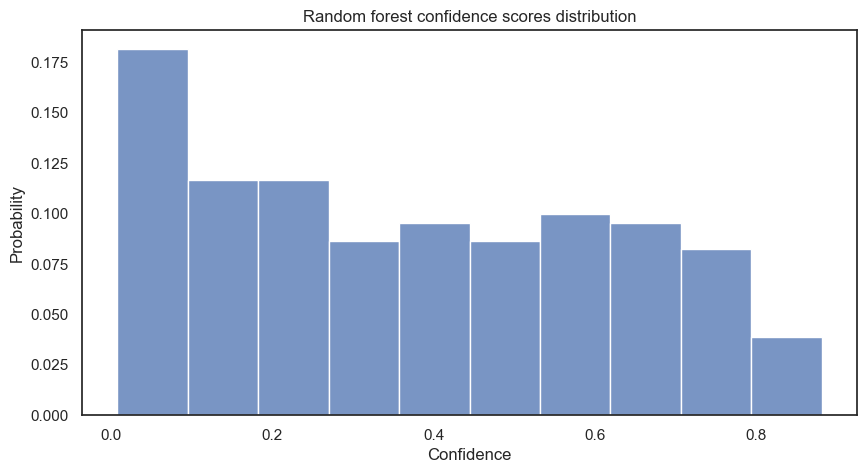

In [36]:
# Create confidence scores
confidence_scores = pd.Series(
    grid_search.best_estimator_.predict_proba(diabetes_x_test)[:, 1]
)

# Print stats
print(
    (
        f"Min:{confidence_scores.min(): .3f}",
        f"Max:{confidence_scores.max(): .3f}",
        f"Mean:{confidence_scores.mean(): .3f}",
        f"Median:{confidence_scores.median(): .3f}"
    )
)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot confidence scores distribution
sns.histplot(confidence_scores, bins=10, stat="probability", ax=ax)

# Show plot
ax.set_xlabel("Confidence")
plt.title("Random forest confidence scores distribution")
plt.show()

Next, let's train the best random forest on all the dataset:

In [37]:
clf = RandomForestClassifier(random_state=SEED, **grid_search.best_params_)
clf = clf.fit(diabetes_X.to_numpy(), diabetes_y.to_numpy().ravel())

Next, let's create a conditional GAN on the diabetes data:

In [38]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = diabetes_X.shape[-1]
c_dim = 1

# Sample confidence scores
c = tf.random.uniform(shape=(1000, c_dim), minval=0, maxval=1)

# Create CGAN
gen = make_generator(latent_dim + c_dim, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + c_dim)
cgan = CGAN(gen, dis, clf, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
)

Next, let's visualize the generator:

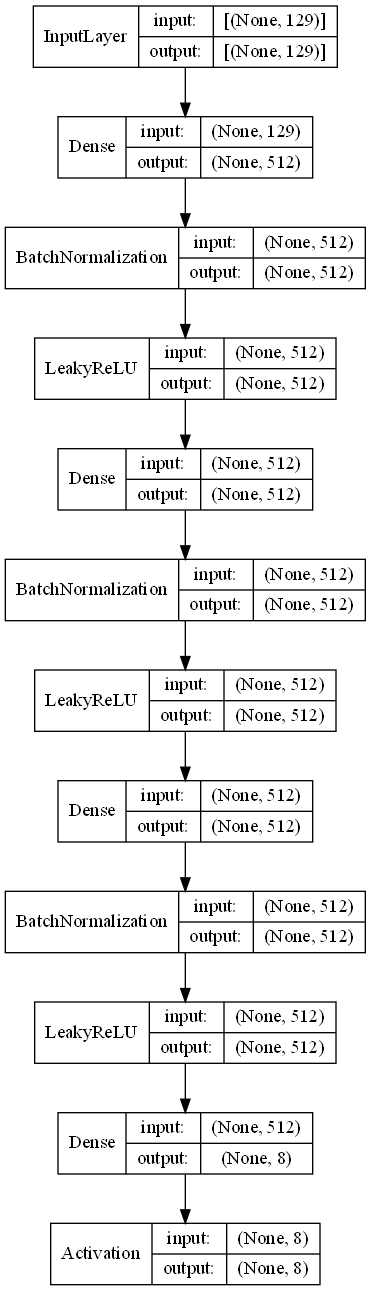

In [39]:
utils.plot_model(
    cgan.generator, show_shapes=True, show_layer_names=False,
    expand_nested=True, rankdir="TB"
)

Next, let's visualize the discriminator:

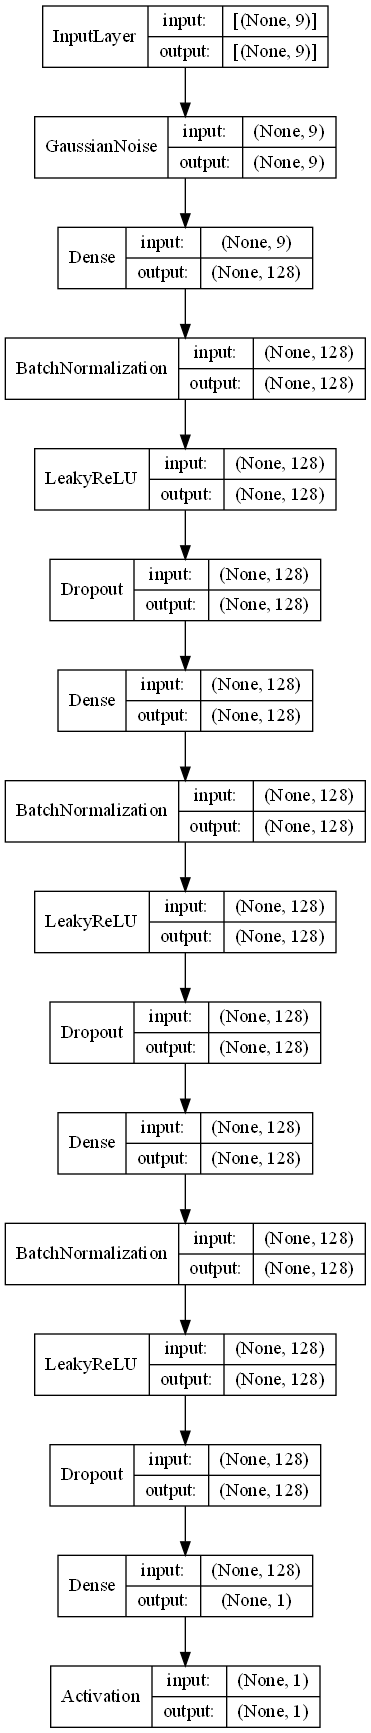

In [40]:
utils.plot_model(
    cgan.discriminator, show_shapes=True, show_layer_names=False,
    expand_nested=True, rankdir="TB"
)

Next, let's train the GAN:

In [41]:
# Train CGAN
history = cgan.fit(
    c, c, epochs=TWIST_NUM_EPOCHS, shuffle=True, batch_size=BATCH_SIZE
)

Epoch 1/400
32/32 [==============================] - 2s 57ms/step - g_loss: 0.6931 - d_loss: 0.6931 - d_y_acc: 0.5770 - d_c_acc: 0.4835
Epoch 2/400
32/32 [==============================] - 2s 57ms/step - g_loss: 0.6933 - d_loss: 0.6930 - d_y_acc: 0.7923 - d_c_acc: 0.4893
Epoch 3/400
32/32 [==============================] - 2s 54ms/step - g_loss: 0.6944 - d_loss: 0.6886 - d_y_acc: 0.9303 - d_c_acc: 0.4521
Epoch 4/400
32/32 [==============================] - 2s 56ms/step - g_loss: 0.7121 - d_loss: 0.6674 - d_y_acc: 1.0000 - d_c_acc: 0.4689
Epoch 5/400
32/32 [==============================] - 2s 53ms/step - g_loss: 0.8047 - d_loss: 0.6268 - d_y_acc: 1.0000 - d_c_acc: 0.4909
Epoch 6/400
32/32 [==============================] - 2s 57ms/step - g_loss: 0.9964 - d_loss: 0.5883 - d_y_acc: 1.0000 - d_c_acc: 0.5153
Epoch 7/400
32/32 [==============================] - 2s 58ms/step - g_loss: 1.1816 - d_loss: 0.5715 - d_y_acc: 1.0000 - d_c_acc: 0.5291
Epoch 8/400
32/32 [=============================

Next, let's plot training metrics:

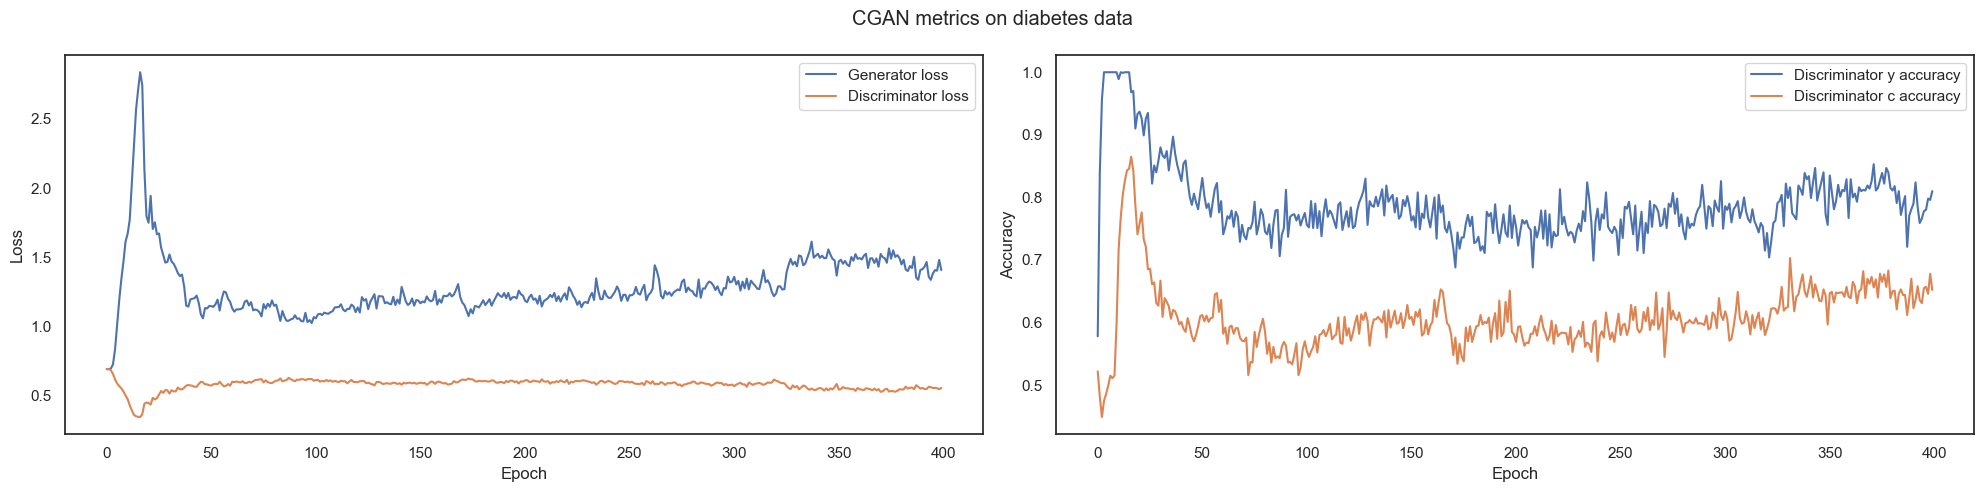

In [42]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_y_acc"], label="Discriminator y accuracy")
ax[1].plot(history.history["d_c_acc"], label="Discriminator c accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on diabetes data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [43]:
# Define number of samples to generate
num_samples = 1000

# Sample random points in the latent space for the generator
# and concatenate the labels.
c = tf.random.uniform(shape=(num_samples, 1), maxval=1, minval=0)
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_c = tf.concat([random_latent_vectors, c], axis=1)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_c)
fake_records_and_c = tf.concat([fake_records, c], axis=1)

# Get discriminator predictions for fake and real dataset
d_c_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_c),
    columns=["discriminator_probability"]
)

# Create a fake data frame
fake_clean_diabetes_df = pd.DataFrame(
    fake_records_and_c.numpy(), columns=clean_diabetes_df.columns
)

# Create class from confidence score
fake_clean_diabetes_df["class"] = fake_clean_diabetes_df["class"].apply(np.rint)

# Inverse preprocess
fake_diabetes_df = inverse_pre_process_data(
    fake_clean_diabetes_df, diabetes_num_cols, diabetes_cat_cols,
    diabetes_l_encoder, diabetes_n_scalar, diabetes_c_encoder
)

# Sort fake data frame columns same as regular data frame columns
fake_diabetes_df = fake_diabetes_df.reindex(diabetes_df.columns, axis=1)

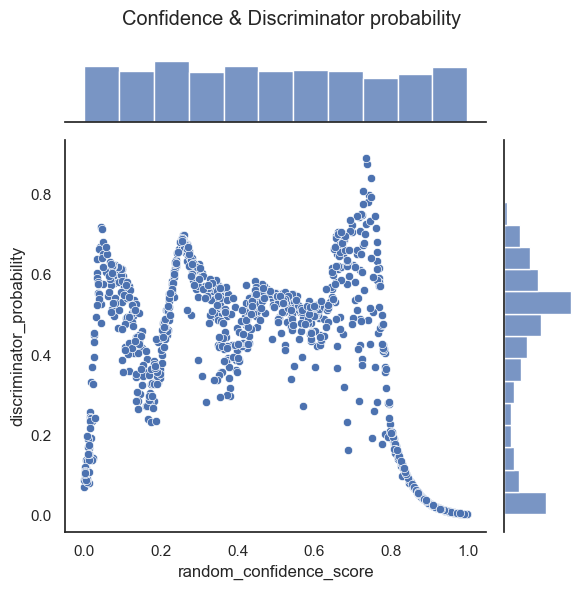

In [44]:
# Add confidence to data frame
d_c_predictions["random_confidence_score"] = c.numpy()

# Plot confidence over discriminator probability
p = sns.jointplot(
    data=d_c_predictions, x="random_confidence_score",
    y="discriminator_probability", height=6
)

# Show plot
p.fig.suptitle("Confidence & Discriminator probability")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.90)
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [45]:
# Get records that fooled the discriminator
fooled = fake_diabetes_df[d_c_predictions["discriminator_probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 484


preg     plas   pres    skin     insu    mass   pedi     age  \
2  0.0036  83.8412 0.0003  0.0045   0.0000 33.6748 0.0899 21.0000   
6  0.0132  97.5203 0.0005  0.0058   0.0001 37.8512 0.1160 21.0000   
7  8.6169  96.8087 0.0124  4.4868 821.2357 66.6213 2.4017 26.6578   
9  0.0001  74.3051 0.0000  0.0017   0.0000 28.3501 0.0787 21.0000   
11 7.1129 125.5543 0.0121 10.8573 796.3124 66.7351 2.4132 27.1626   
13 7.8048  97.1313 0.0076  0.2409 753.7131 65.7377 2.3946 22.7101   
16 6.0867 146.0002 0.0036 53.7727 815.5380 67.0044 2.4159 23.3536   
17 0.0120  91.3802 0.0004  0.0046   0.0002 35.6372 0.1042 21.0000   
18 5.1368 109.3468 0.0003  0.0040 179.9114 63.8891 2.3417 21.0235   
23 0.0010  78.3077 0.0001  0.0031   0.0000 32.4203 0.0826 21.0000   

              class  
2   tested_negative  
6   tested_negative  
7   tested_positive  
9   tested_negative  
11  tested_positive  
13  tested_positive  
16  tested_positive  
17  tested_negative  
18  tested_positive  
23  tested_negative

In [46]:
# Get records that did not fool the discriminator
not_fooled = fake_diabetes_df[
    d_c_predictions["discriminator_probability"] <= 0.5]
# Print number of not fooled records
print(
    (
        f"Number of sample that did not fool the discriminator:"
        f" {not_fooled.shape[0]}"
    )
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 516


preg     plas   pres    skin     insu    mass   pedi     age  \
0  0.0026 198.9902 0.0000 99.0000   1.3907 67.1000 2.4200 21.0001   
1  0.3636 197.3423 0.0002 98.9166 196.7814 67.0948 2.4199 21.0952   
3  0.7627 119.4860 0.0014  0.0164   0.4732 51.9765 1.3079 21.0010   
4  0.0020  80.0594 0.0004  0.0085   0.0000 32.6375 0.0867 21.0000   
5  0.0289 198.8855 0.0000 98.9988  18.8434 67.0996 2.4200 21.0032   
8  1.5920 119.1786 0.0008  0.0132   3.3880 57.1847 2.0076 21.0025   
10 0.0012  79.2941 0.0002  0.0040   0.0000 32.7849 0.0831 21.0000   
12 0.0001 198.9996 0.0000 99.0000   0.0131 67.1000 2.4200 21.0000   
14 0.0003 198.9984 0.0000 99.0000   0.1147 67.1000 2.4200 21.0000   
15 1.0608 193.4161 0.0008 97.6344 541.7171 67.0848 2.4195 21.3353   

              class  
0   tested_positive  
1   tested_positive  
3   tested_negative  
4   tested_negative  
5   tested_positive  
8   tested_negative  
10  tested_negative  
12  tested_positive  
14  tested_positive  
15  tested_positive

Lets evaluate the generated samples using table evaluator:

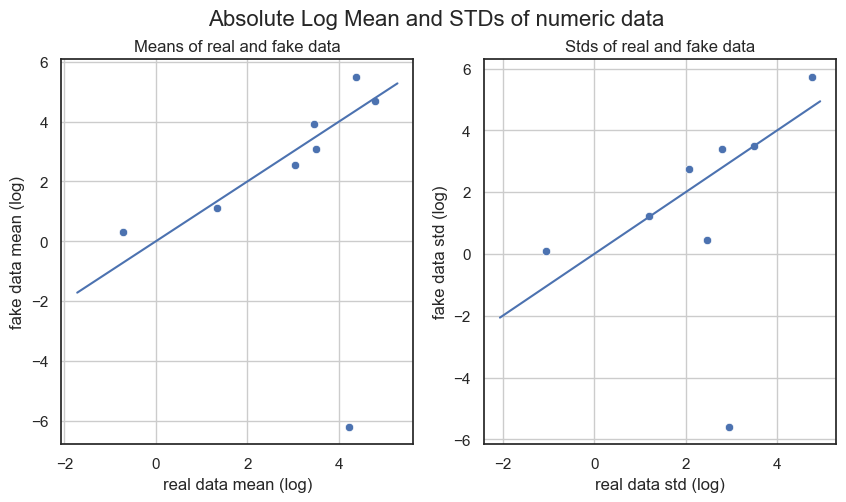

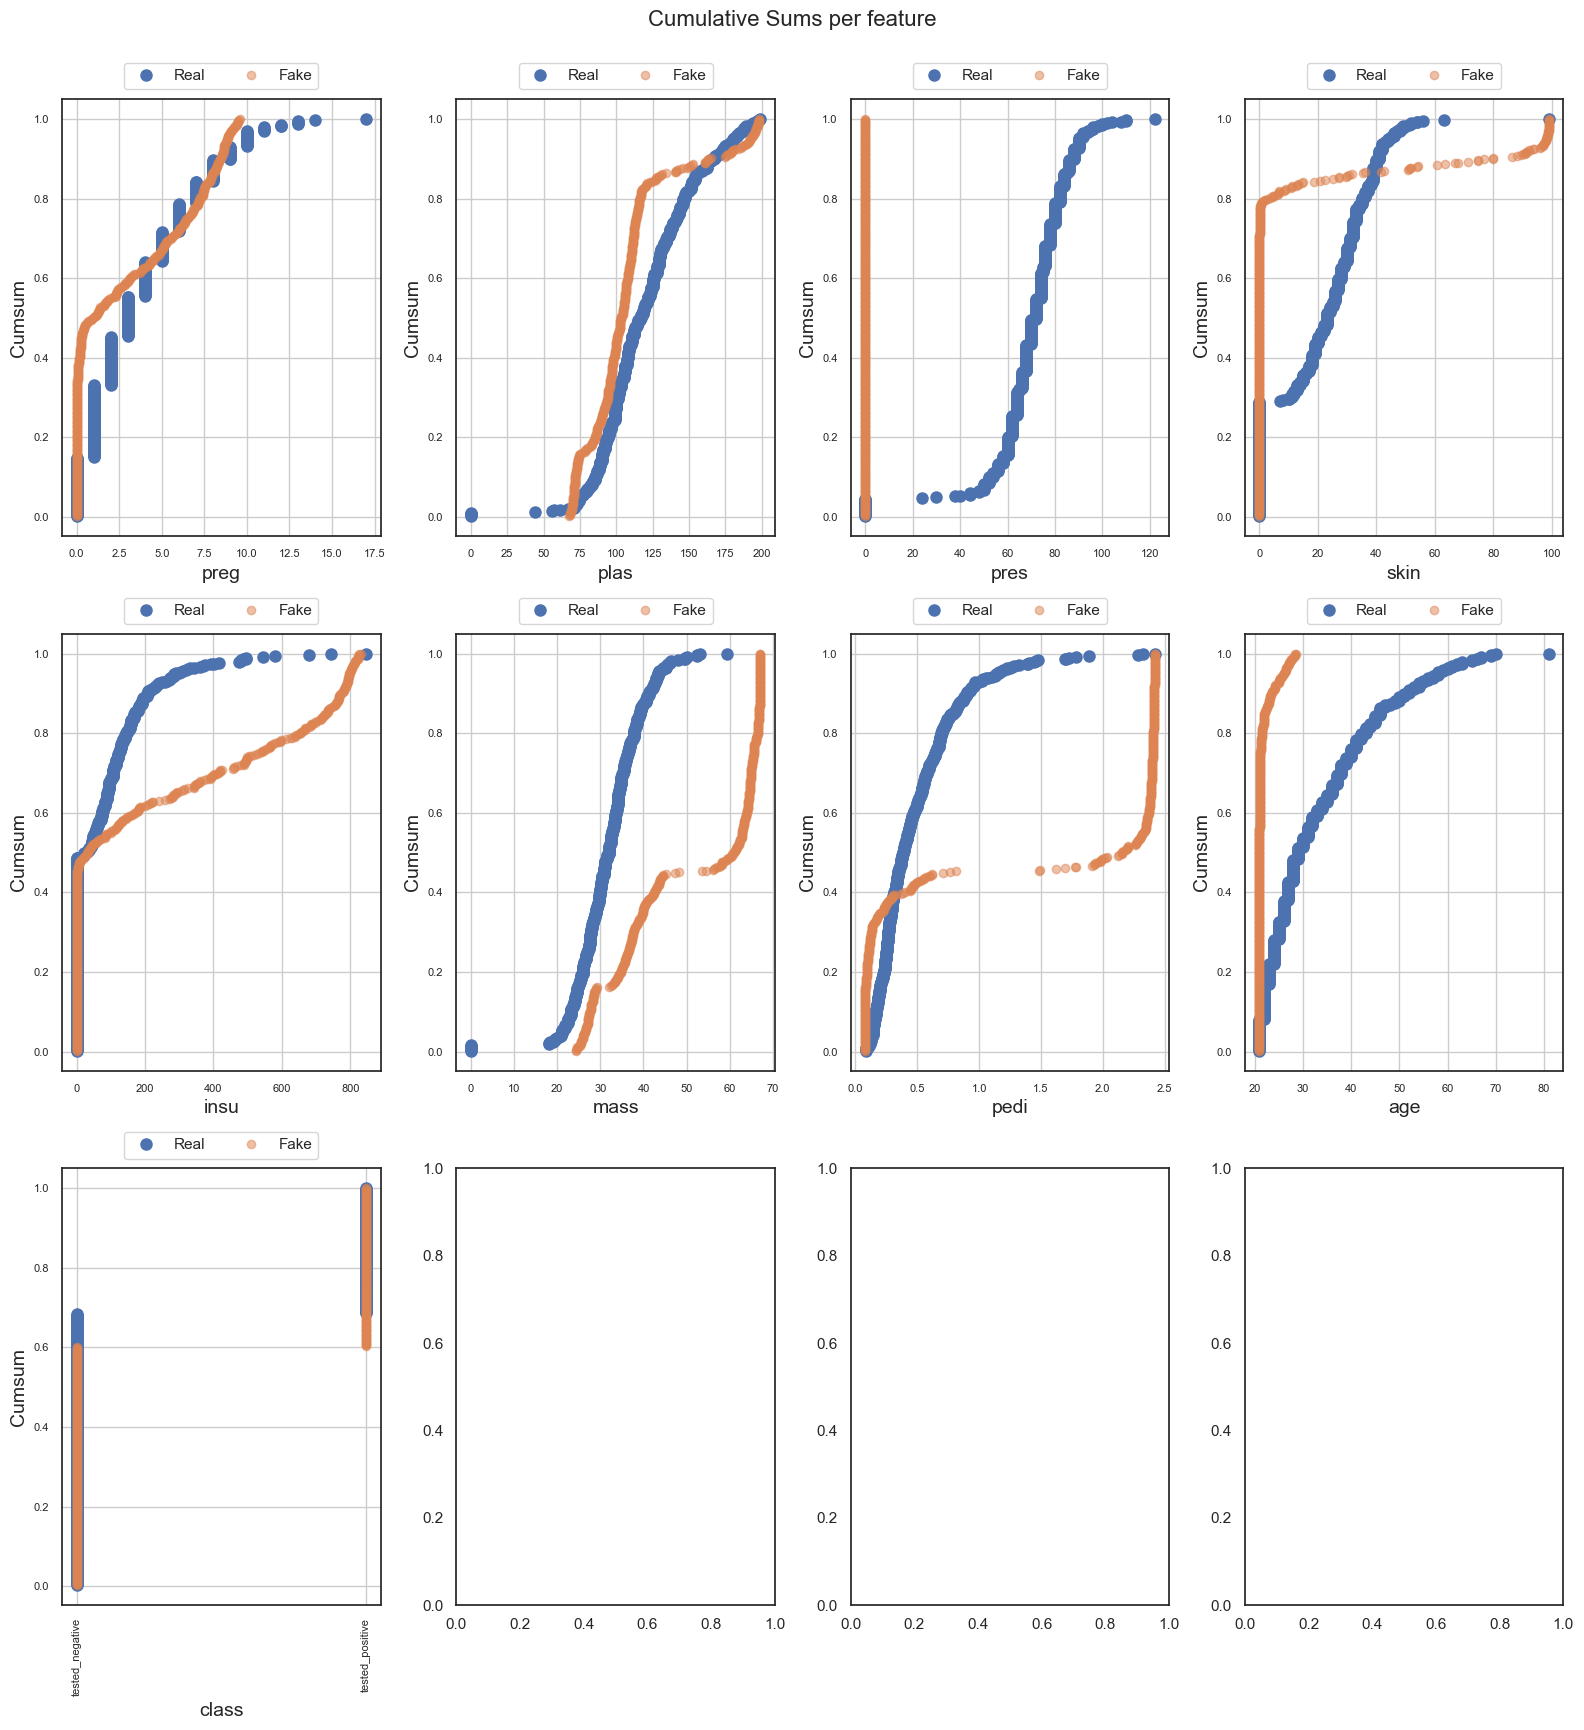

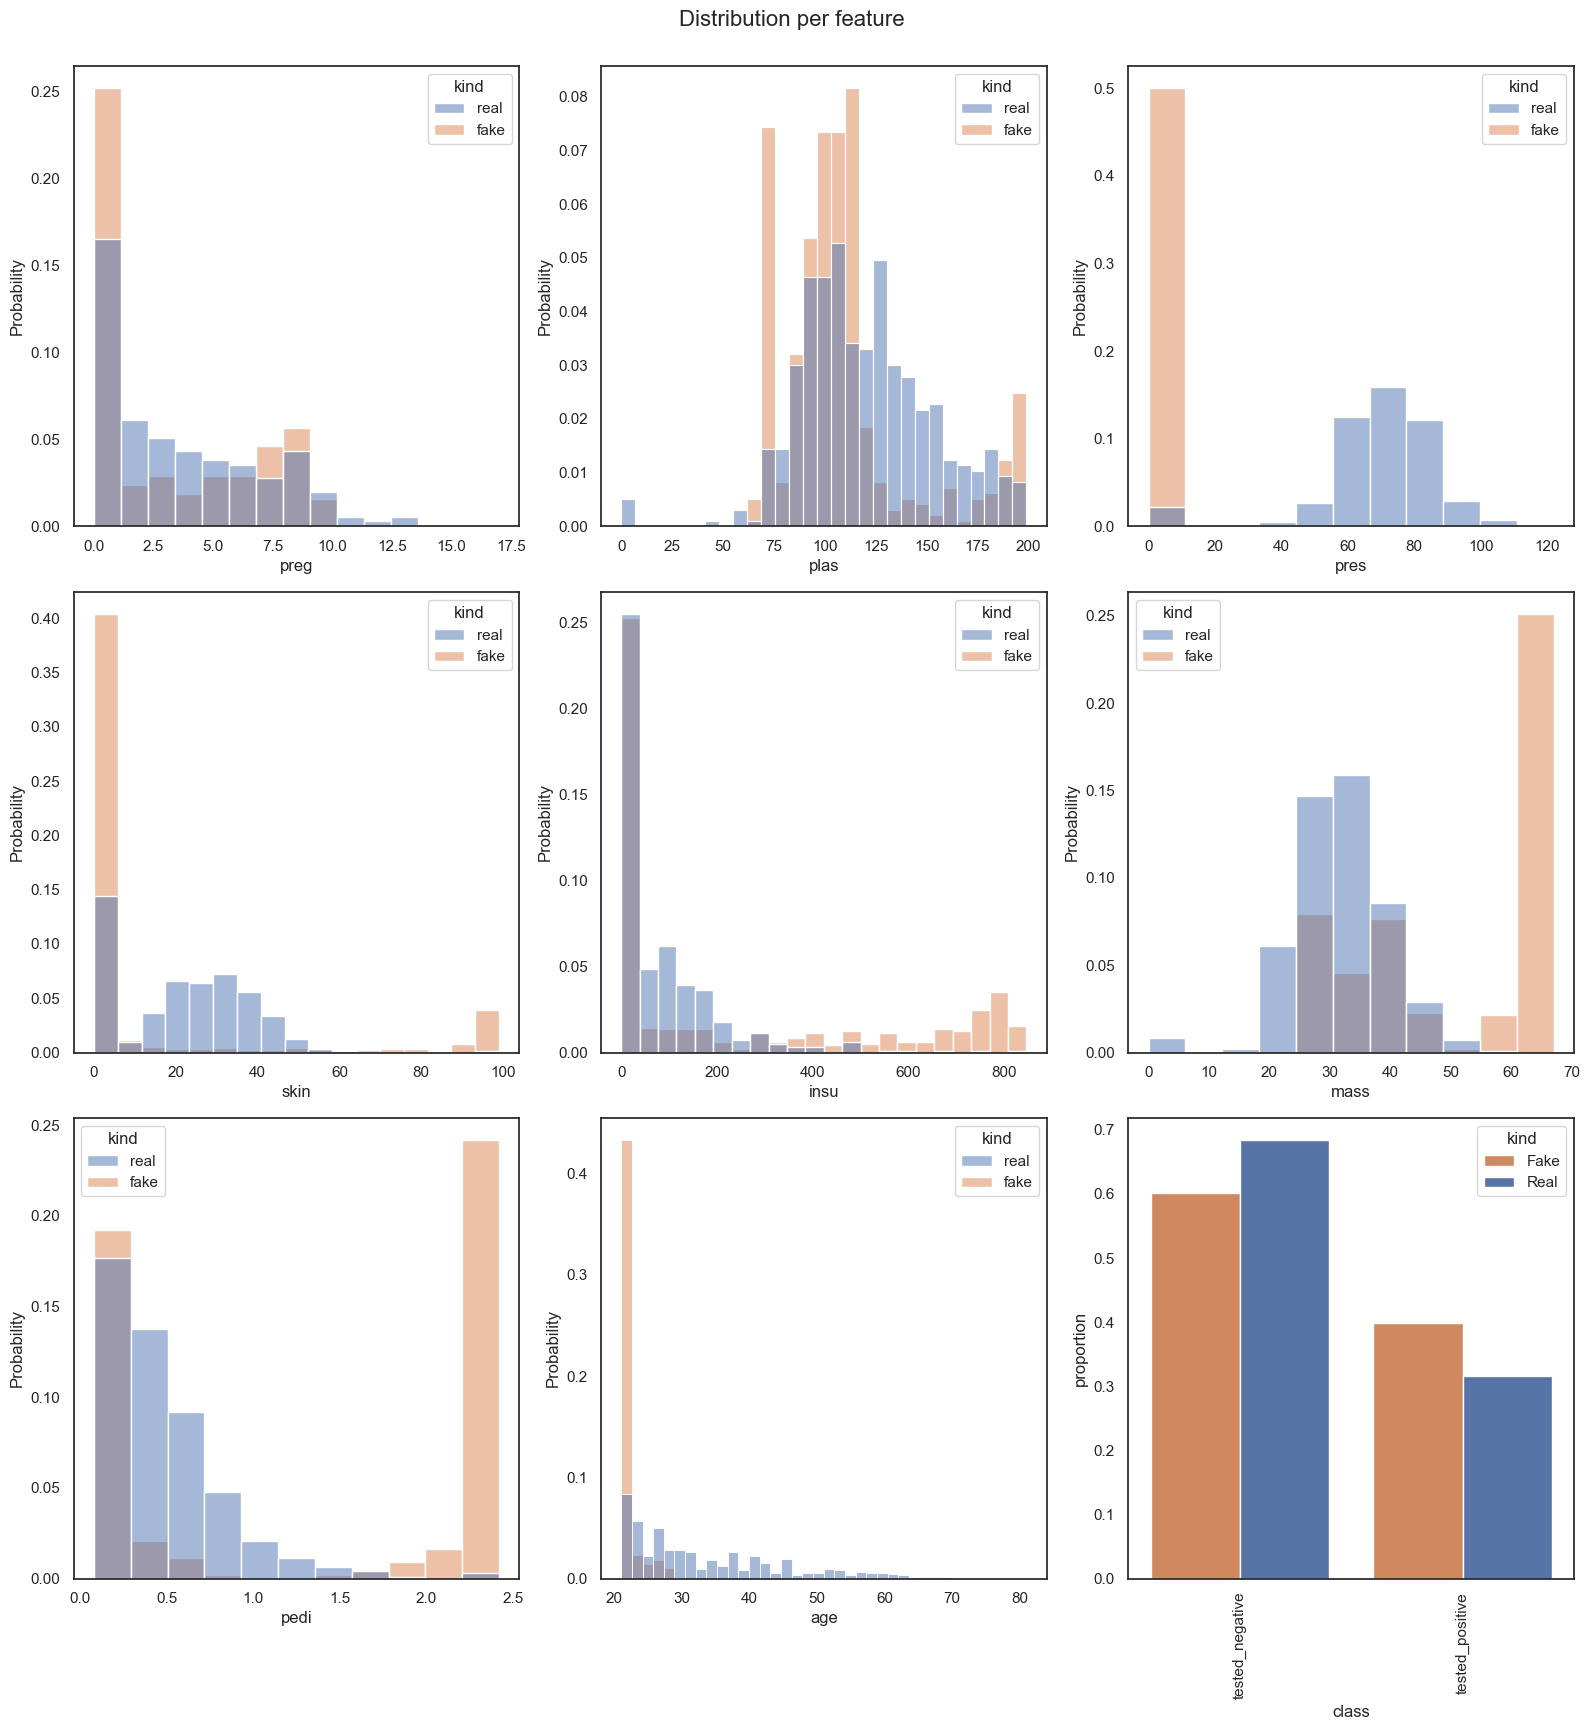

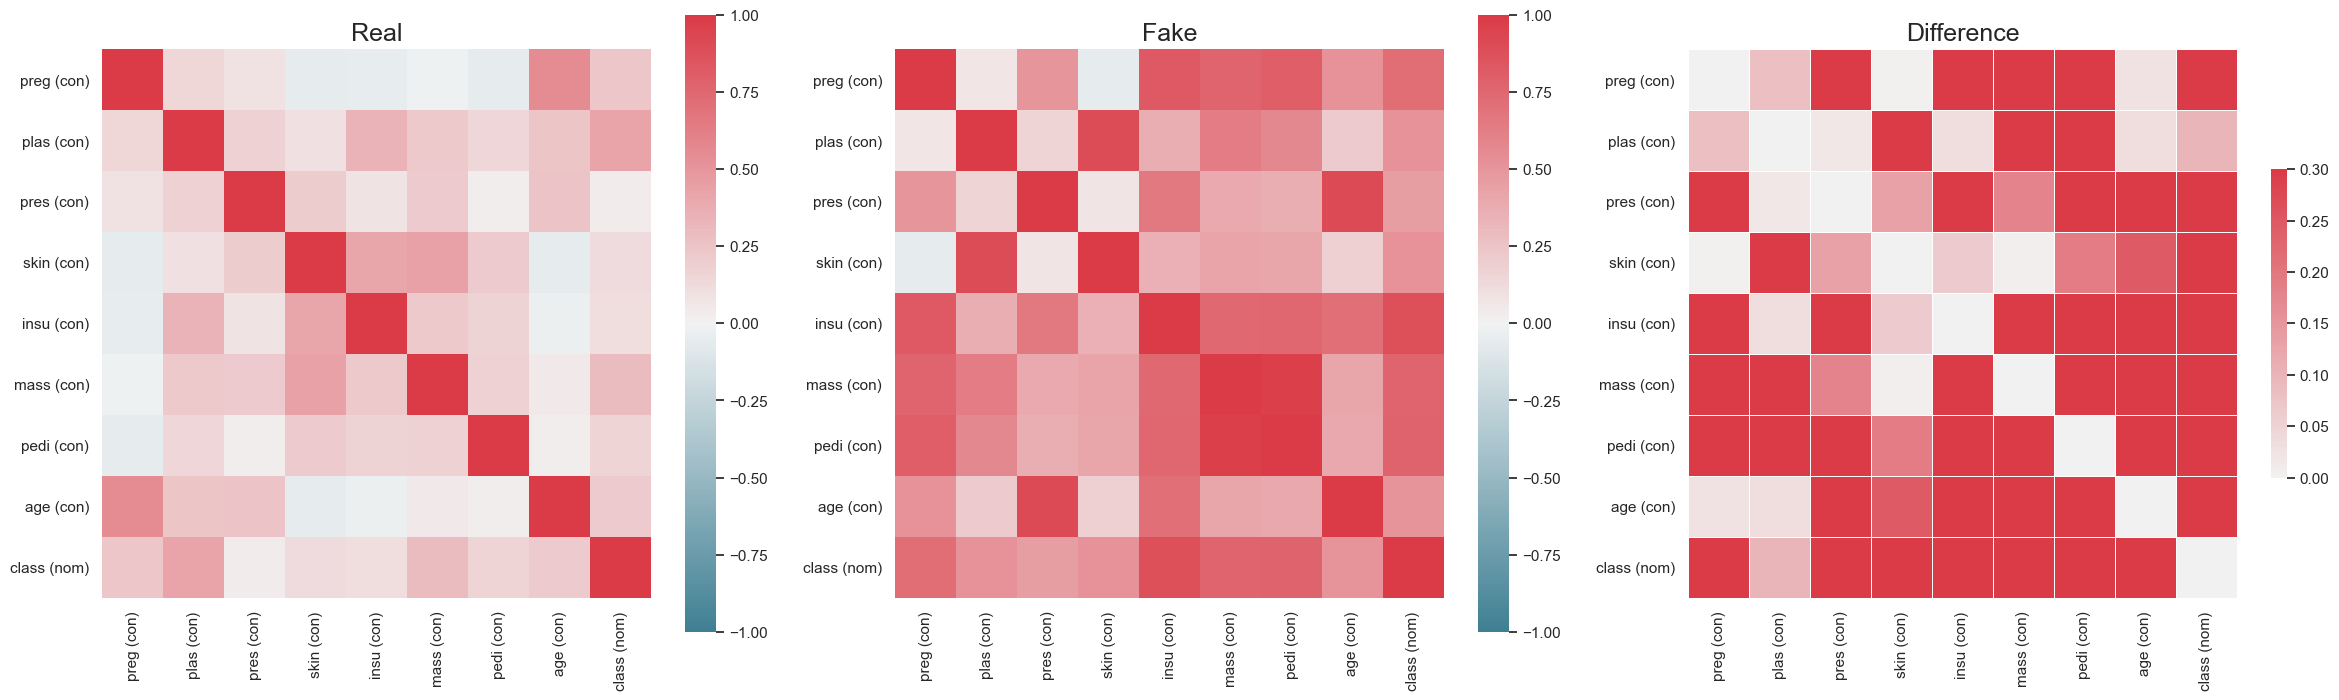

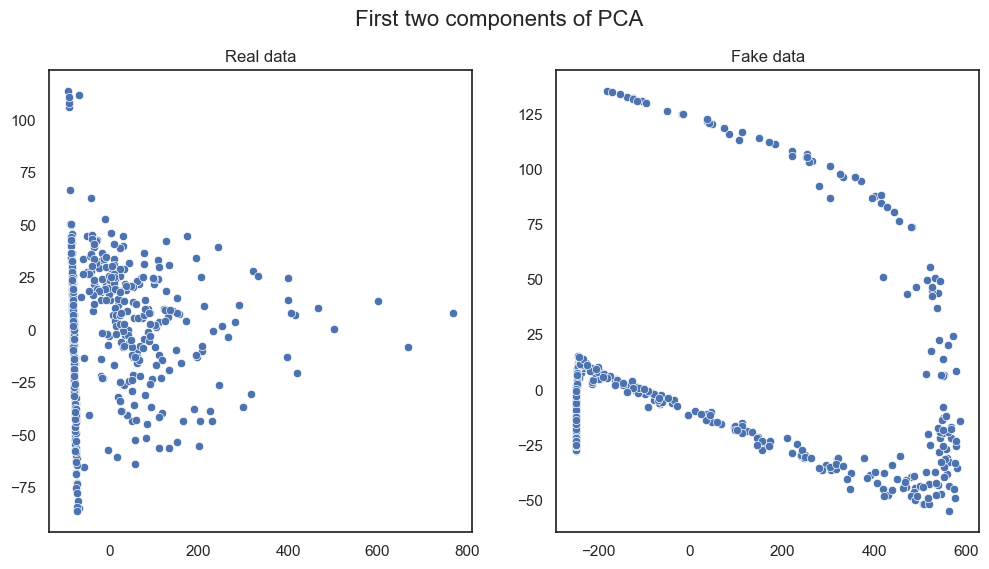


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6392   0.9897              0.4809
DecisionTreeClassifier_real   0.7216   0.7526              0.5156
LogisticRegression_fake       0.7423   0.9897              0.5772
LogisticRegression_real       0.8041   0.7526              0.7321
MLPClassifier_fake            0.2371   0.9897              0.1279
MLPClassifier_real            0.7113   0.5052              0.3566
RandomForestClassifier_fake   0.8660   0.9897              0.7798
RandomForestClassifier_real   0.7732   0.7629              0.6441

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    2.3013
nearest neighbor std                     0.8552

Miscellaneous results:
                                  Result
Column Cor

In [47]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    diabetes_df, fooled.reset_index(drop=True),
    cat_cols=diabetes_cat_cols + ["class"]
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")

##### ***German Credit training & evaluation***

Next, let's train a conditional GAN on the germen credit data:

In [48]:
# Split data to train-test sets
g_credit_x_train, g_credit_x_test, g_credit_y_train, g_credit_y_test = (
    train_test_split(
        g_credit_X.to_numpy(), g_credit_y.to_numpy(), test_size=TEST_SIZE,
        random_state=SEED
    )
)

# Define grid search parameters
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [2, 4, 6],
    "min_samples_split": [2, 6, 10],
    "min_samples_leaf": [1, 3, 4]
}

# Create grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=SEED), param_grid,
    cv=StratifiedKFold(n_splits=5)
)

# Fit grid search
grid_search.fit(g_credit_x_train, g_credit_y_train.ravel())

# Print best score and parameters and test score
print(f"Best score {grid_search.best_score_}:")
print(f"Best parameters: {grid_search.best_params_}")
print(
    (
        f"Test score: "
        f"{grid_search.best_estimator_.score(g_credit_x_test, g_credit_y_test)}"
    )
)

Best score 0.7414285714285714:
Best parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Test score: 0.7366666666666667


Next, let's plot confidence score distribution:

('Min: 0.056', 'Max: 0.693', 'Mean: 0.294', 'Median: 0.279')


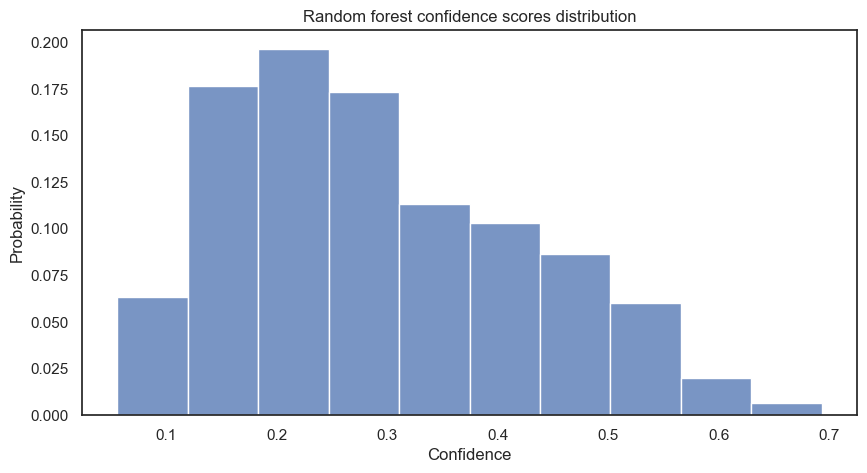

In [49]:
# Create confidence scores
confidence_scores = pd.Series(
    grid_search.best_estimator_.predict_proba(g_credit_x_test)[:, 1]
)

# Print stats
print(
    (
        f"Min:{confidence_scores.min(): .3f}",
        f"Max:{confidence_scores.max(): .3f}",
        f"Mean:{confidence_scores.mean(): .3f}",
        f"Median:{confidence_scores.median(): .3f}"
    )
)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot confidence scores distribution
sns.histplot(confidence_scores, bins=10, stat="probability", ax=ax)

# Show plot
ax.set_xlabel("Confidence")
plt.title("Random forest confidence scores distribution")
plt.show()

Next, let's train the best random forest on all the dataset:

In [50]:
clf = RandomForestClassifier(random_state=SEED, **grid_search.best_params_)
clf = clf.fit(g_credit_X.to_numpy(), g_credit_y.to_numpy().ravel())

Next, let's create a conditional GAN on the diabetes data:

In [51]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = g_credit_X.shape[-1]
c_dim = 1

# Sample confidence scores
c = tf.random.uniform(shape=(1000, c_dim), minval=0, maxval=1)

# Create CGAN
gen = make_generator(latent_dim + c_dim, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + c_dim)
cgan = CGAN(gen, dis, clf, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
)

Next, let's visualize the generator:

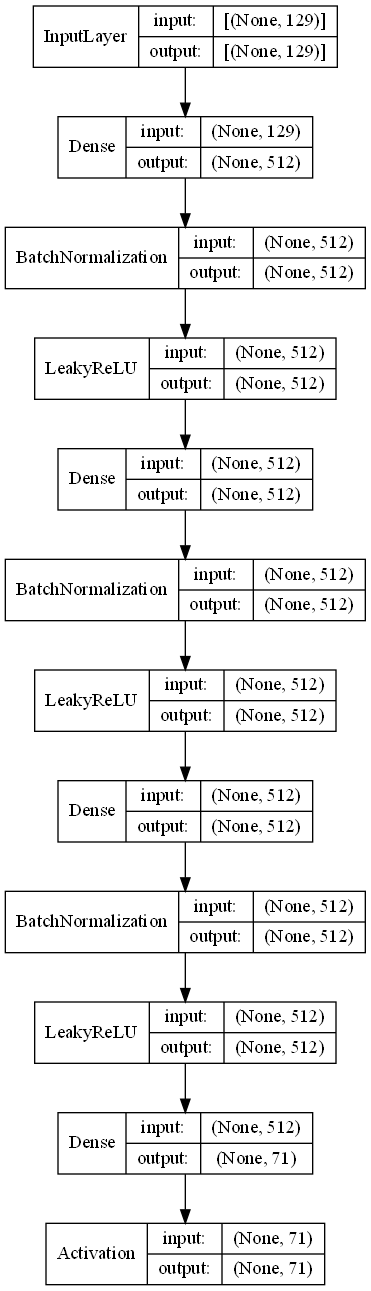

In [52]:
utils.plot_model(
    cgan.generator, show_shapes=True, show_layer_names=False,
    expand_nested=True, rankdir="TB"
)

Next, let's visualize the discriminator:

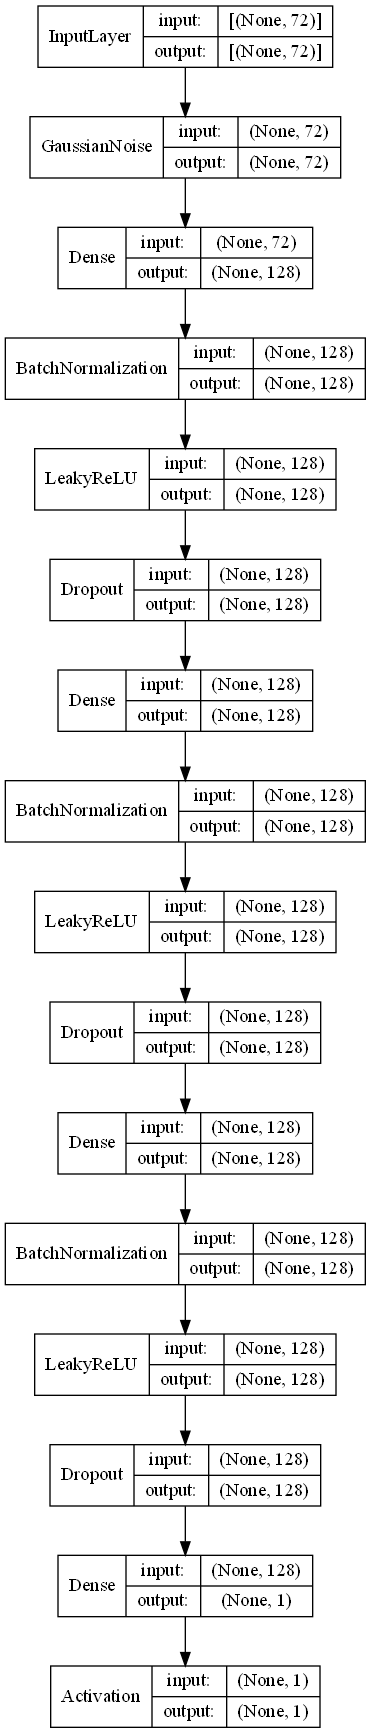

In [53]:
utils.plot_model(
    cgan.discriminator, show_shapes=True, show_layer_names=False,
    expand_nested=True, rankdir="TB"
)

Next, let's train the GAN:

In [54]:
# Train CGAN
history = cgan.fit(
    c, c, epochs=TWIST_NUM_EPOCHS, shuffle=True, batch_size=BATCH_SIZE
)

Epoch 1/400
32/32 [==============================] - 2s 57ms/step - g_loss: 0.6931 - d_loss: 0.6930 - d_y_acc: 0.6981 - d_c_acc: 0.4342
Epoch 2/400
32/32 [==============================] - 2s 56ms/step - g_loss: 0.6937 - d_loss: 0.6914 - d_y_acc: 0.5867 - d_c_acc: 0.5037
Epoch 3/400
32/32 [==============================] - 2s 57ms/step - g_loss: 0.6823 - d_loss: 0.6901 - d_y_acc: 0.8908 - d_c_acc: 0.3331
Epoch 4/400
32/32 [==============================] - 2s 57ms/step - g_loss: 0.6864 - d_loss: 0.6931 - d_y_acc: 0.7259 - d_c_acc: 0.3115
Epoch 5/400
32/32 [==============================] - 2s 59ms/step - g_loss: 0.6970 - d_loss: 0.6927 - d_y_acc: 0.6718 - d_c_acc: 0.3802
Epoch 6/400
32/32 [==============================] - 2s 57ms/step - g_loss: 0.6853 - d_loss: 0.6933 - d_y_acc: 1.0000 - d_c_acc: 0.0668
Epoch 7/400
32/32 [==============================] - 2s 61ms/step - g_loss: 0.6923 - d_loss: 0.6933 - d_y_acc: 0.8573 - d_c_acc: 0.3983
Epoch 8/400
32/32 [=============================

Next, let's plot training metrics:

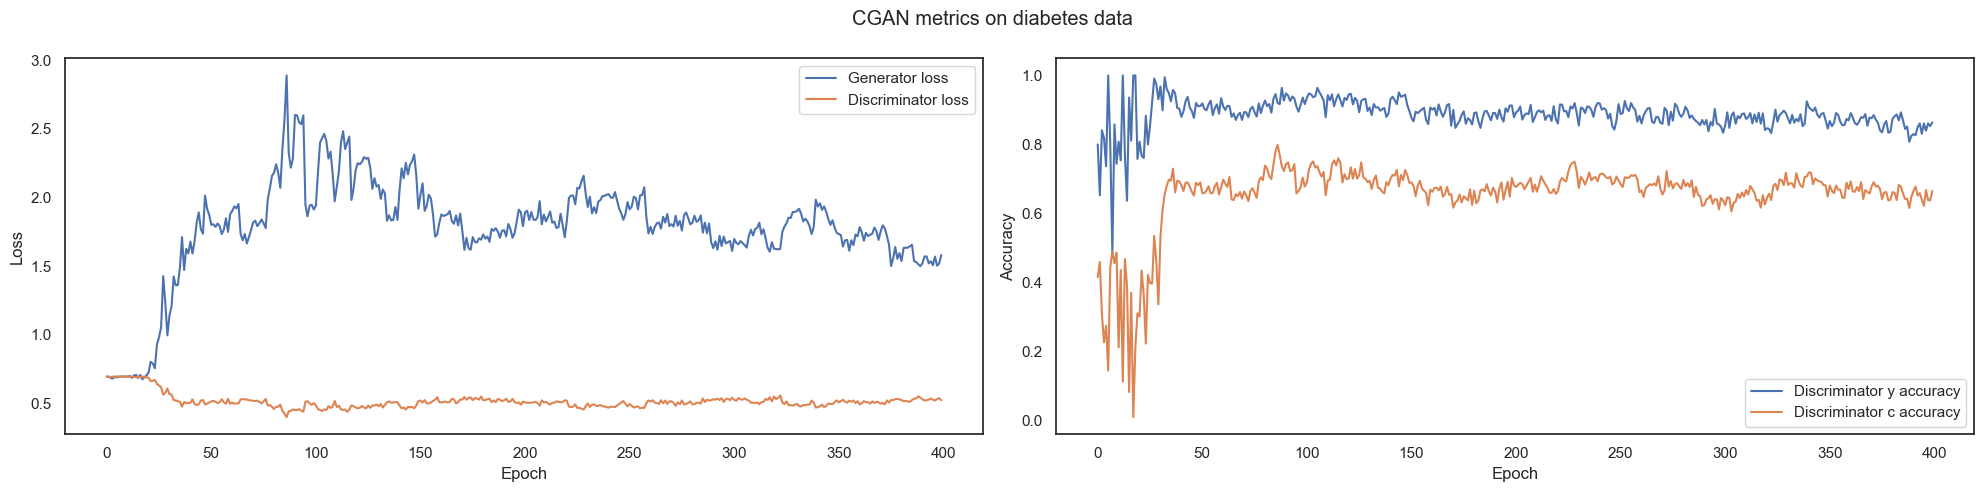

In [55]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_y_acc"], label="Discriminator y accuracy")
ax[1].plot(history.history["d_c_acc"], label="Discriminator c accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on diabetes data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [56]:
# Define number of samples to generate
num_samples = 1000

# Sample random points in the latent space for the generator
# and concatenate the labels.
c = tf.random.uniform(shape=(num_samples, 1), maxval=1, minval=0)
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_c = tf.concat([random_latent_vectors, c], axis=1)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_c)
fake_records_and_c = tf.concat([fake_records, c], axis=1)

# Get discriminator predictions for fake and real dataset
d_c_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_c),
    columns=["discriminator_probability"]
)

# Create a fake data frame
fake_clean_g_credit_df = pd.DataFrame(
    fake_records_and_c.numpy(), columns=clean_g_credit_df.columns
)

# Create class from confidence score
fake_clean_g_credit_df["class"] = fake_clean_g_credit_df["class"].apply(np.rint)

# Inverse preprocess
fake_g_credit_df = inverse_pre_process_data(
    fake_clean_g_credit_df, g_credit_num_cols, g_credit_cat_cols,
    g_credit_l_encoder, g_credit_n_scalar, g_credit_c_encoder
)

# Sort fake data frame columns same as regular data frame columns
fake_g_credit_df = fake_g_credit_df.reindex(g_credit_df.columns, axis=1)

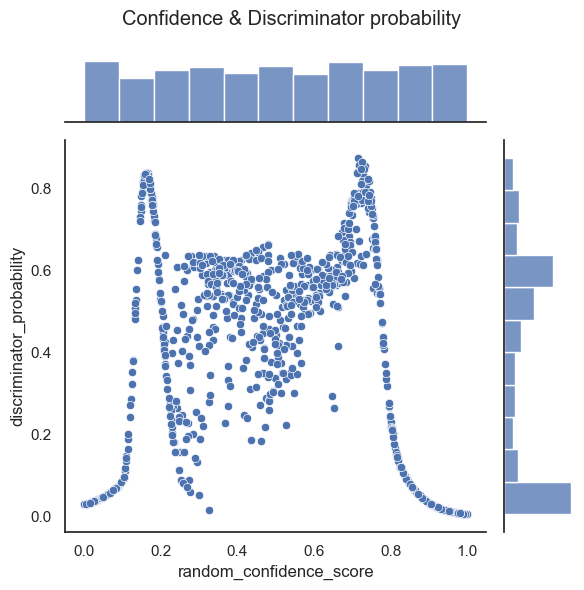

In [57]:
# Add confidence to data frame
d_c_predictions["random_confidence_score"] = c.numpy()

# Plot confidence over discriminator probability
p = sns.jointplot(
    data=d_c_predictions, x="random_confidence_score",
    y="discriminator_probability", height=6
)

# Show plot
p.fig.suptitle("Confidence & Discriminator probability")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.90)
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [58]:
# Get records that fooled the discriminator
fooled = fake_g_credit_df[d_c_predictions["discriminator_probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 454


1       2    3    4           5    6    7      8    9    10  ...    12  \
4   A11 71.8687  A32  A45 18,420.8984  A63  A72 1.0000  A93  A103  ...  A123   
6   A11  6.5634  A34  A45 14,295.8076  A65  A74 2.0000  A94  A103  ...  A123   
8   A11 18.4878  A34  A45 16,595.5645  A63  A71 2.0000  A94  A103  ...  A123   
11  A11  4.9940  A34  A45 12,749.1338  A65  A74 2.0000  A94  A103  ...  A123   
12  A11  4.3758  A34  A45 11,271.3945  A65  A74 2.0000  A94  A103  ...  A123   
20  A11  4.0062  A34  A40  4,979.4521  A65  A74 3.0000  A94  A103  ...  A123   
22  A11  4.0040  A34  A40  4,244.2627  A65  A74 3.0000  A94  A103  ...  A123   
24  A11 71.9755  A30  A41 18,423.9453  A63  A72 1.0000  A93  A103  ...  A123   
25  A11  4.0481  A34  A45  6,888.2568  A65  A74 2.0000  A94  A103  ...  A123   
26  A11  4.2079  A34  A45 10,371.5811  A65  A74 2.0000  A94  A103  ...  A123   

        13    14    15     16    17     18    19    20 class  
4  19.0000  A142  A153 2.0000  A172 1.0000  A192  A201     2  
6  20.0901  A142  A152 3.0000  A173 2.0000  A192  A201     1  
8  19.0585  A142  A151 3.0000  A172 2.0000  A192  A201     2  
11 28.3713  A142  A152 3.0000  A173 2.0000  A192  A201     1  
12 48.4034  A142  A152 3.0000  A173 2.0000  A192  A201     1  
20 74.4663  A143  A151 3.0000  A173 2.0000  A191  A201     1  
22 74.6387  A143  A151 3.0000  A173 2.0000  A191  A202     1  
24 19.0000  A142  A153 2.0000  A173 1.0000  A192  A201     2  
25 72.1009  A143  A152 3.0000  A173 2.0000  A191  A201     1  
26 58.9223  A143  A152 3.0000  A173 2.0000  A191  A201     1  

[10 rows x 21 columns]

In [59]:
# Get records that did not fool the discriminator
not_fooled = fake_g_credit_df[
    d_c_predictions["discriminator_probability"] <= 0.5]
# Print number of not fooled records
print(
    (
        f"Number of sample that did not fool the discriminator:"
        f" {not_fooled.shape[0]}"
    )
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 546


1       2    3    4           5    6    7      8    9    10  ...    12  \
0   A11 71.9934  A30  A41 18,423.9980  A63  A72 1.0000  A93  A103  ...  A123   
1   A14  4.0000  A34  A40    537.3464  A65  A74 3.0000  A94  A101  ...  A123   
2   A11  4.1783  A34  A45 10,032.6973  A65  A74 2.0000  A94  A103  ...  A123   
3   A11 23.9207  A34  A45 16,640.6719  A63  A71 2.0000  A94  A103  ...  A123   
5   A11  4.5831  A34  A45 12,071.4697  A65  A74 2.0000  A94  A103  ...  A123   
7   A11 71.9993  A30  A41 18,424.0000  A61  A72 1.0000  A92  A103  ...  A122   
9   A11 71.9977  A30  A41 18,424.0000  A61  A72 1.0000  A93  A103  ...  A123   
10  A11 71.9951  A30  A41 18,424.0000  A61  A72 1.0000  A93  A103  ...  A123   
13  A11 71.9976  A30  A41 18,424.0000  A61  A72 1.0000  A93  A103  ...  A123   
14  A11 68.2401  A32  A45 18,235.2598  A63  A72 2.0000  A93  A103  ...  A123   

        13    14    15     16    17     18    19    20 class  
0  19.0000  A142  A153 2.0000  A173 1.0000  A192  A201     2  
1  74.9972  A143  A151 2.0000  A173 2.0000  A191  A202     1  
2  63.8912  A143  A152 3.0000  A173 2.0000  A191  A201     1  
3  19.0344  A142  A151 3.0000  A172 2.0000  A192  A201     1  
5  35.4762  A142  A152 3.0000  A173 2.0000  A192  A201     1  
7  19.0000  A142  A153 2.0000  A173 1.0000  A192  A201     2  
9  19.0000  A142  A153 2.0000  A173 1.0000  A192  A201     2  
10 19.0000  A142  A153 2.0000  A173 1.0000  A192  A201     2  
13 19.0000  A142  A153 2.0000  A173 1.0000  A192  A201     2  
14 19.0001  A142  A151 2.0000  A172 1.0000  A192  A201     2  

[10 rows x 21 columns]

Lets evaluate the generated samples using table evaluator:

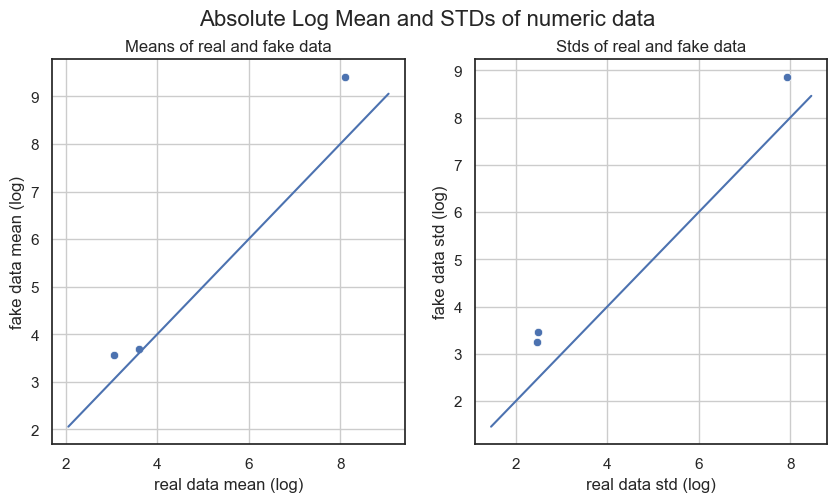

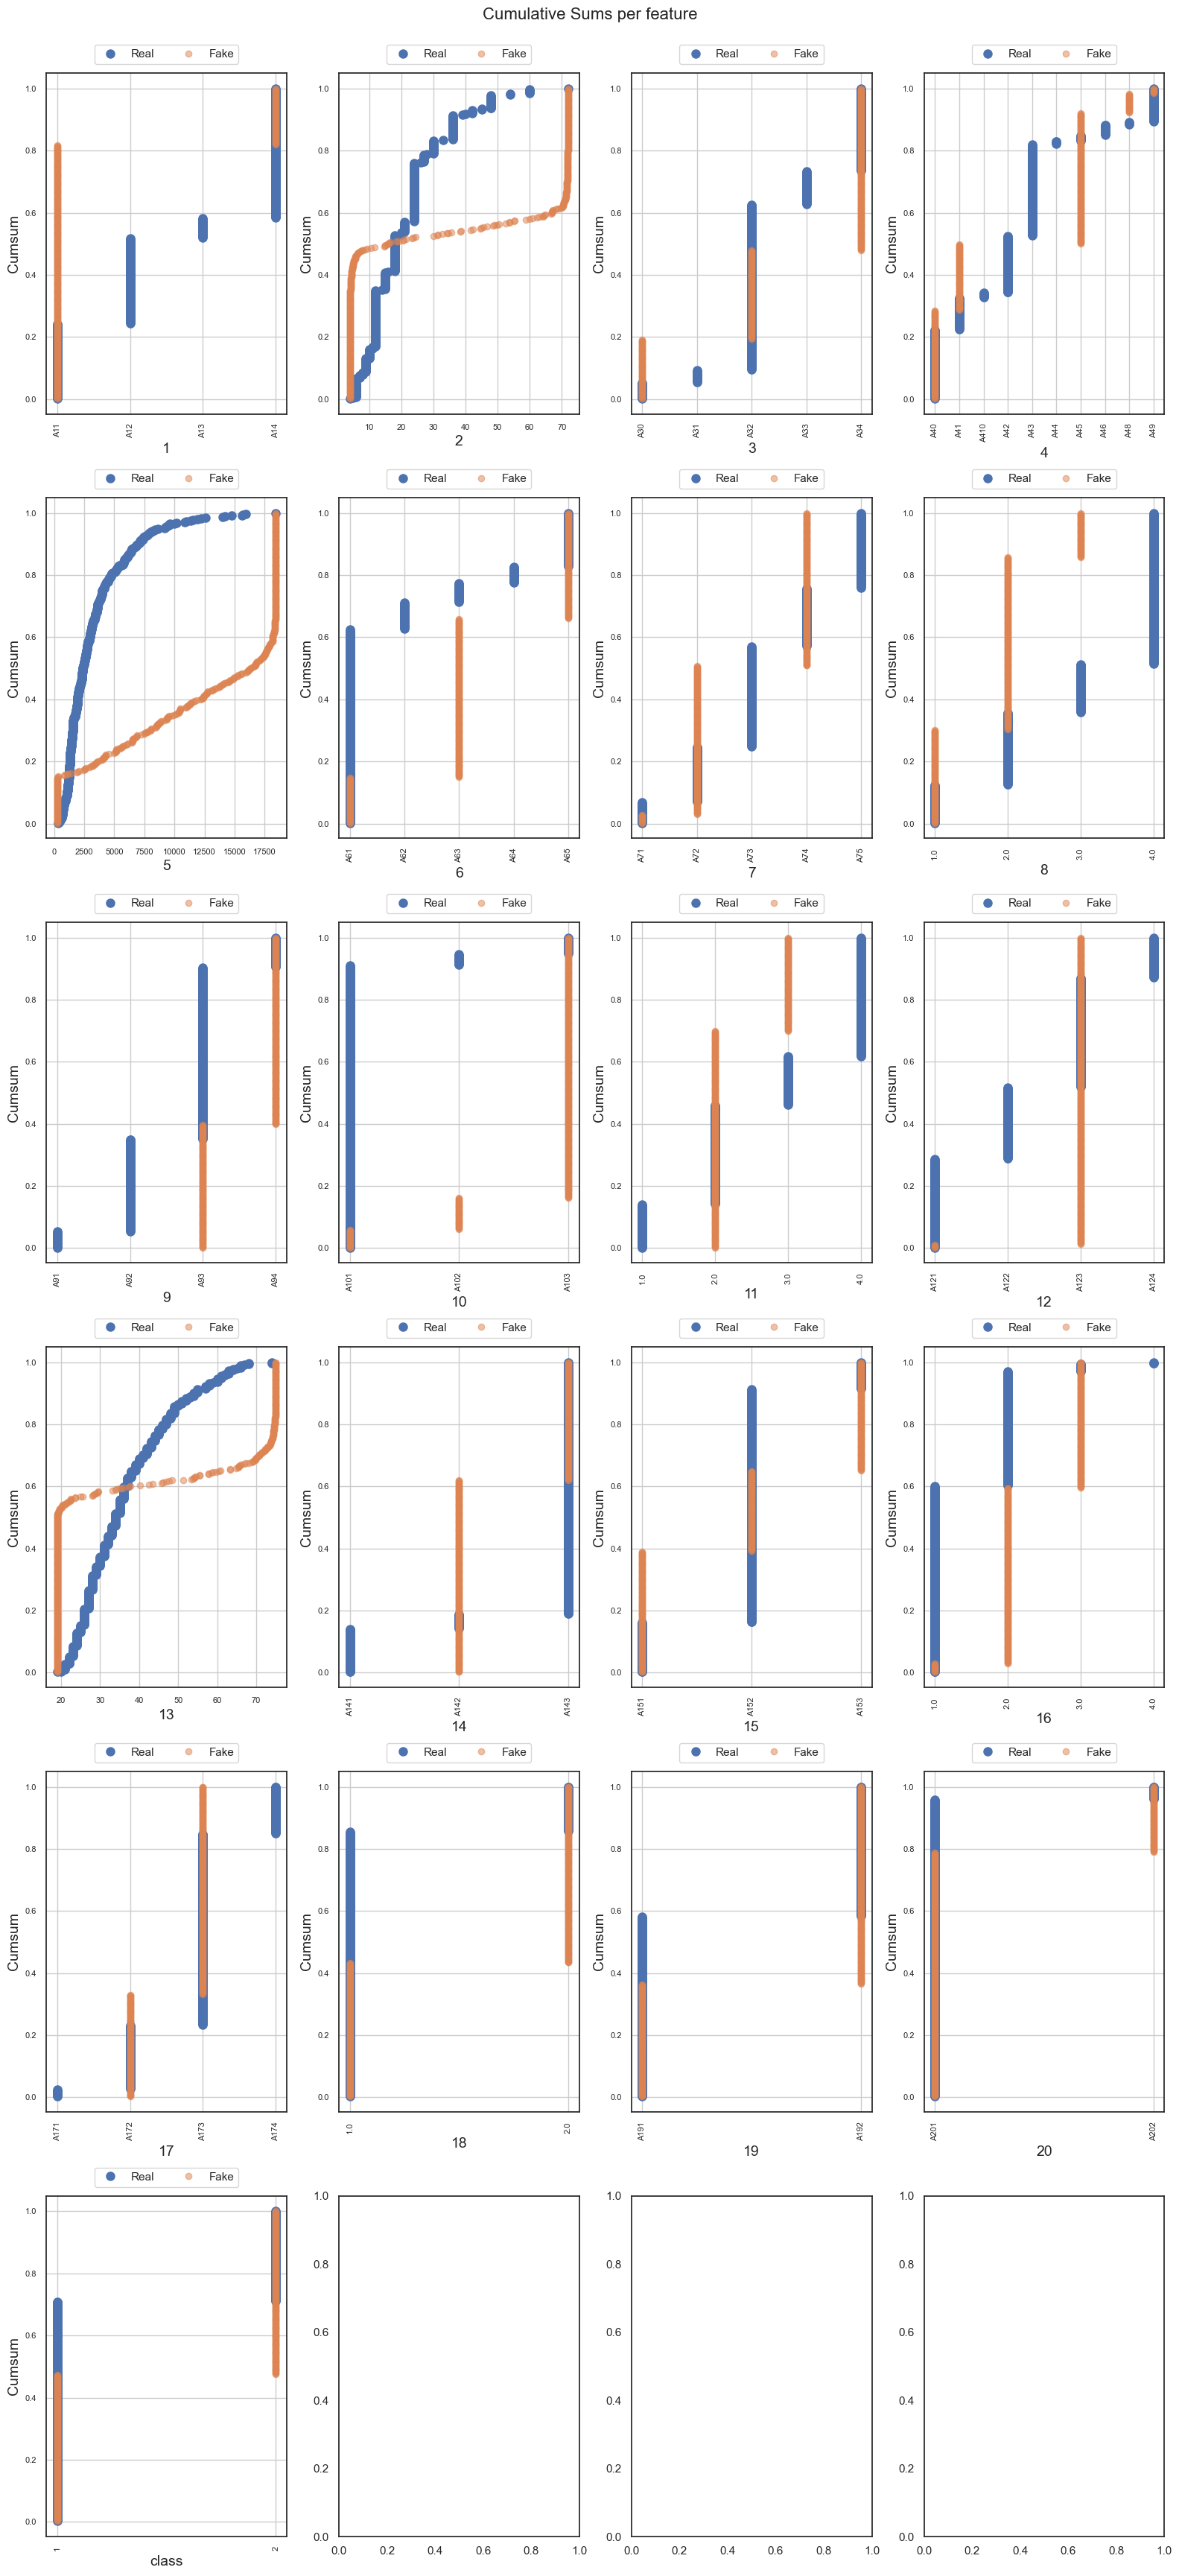

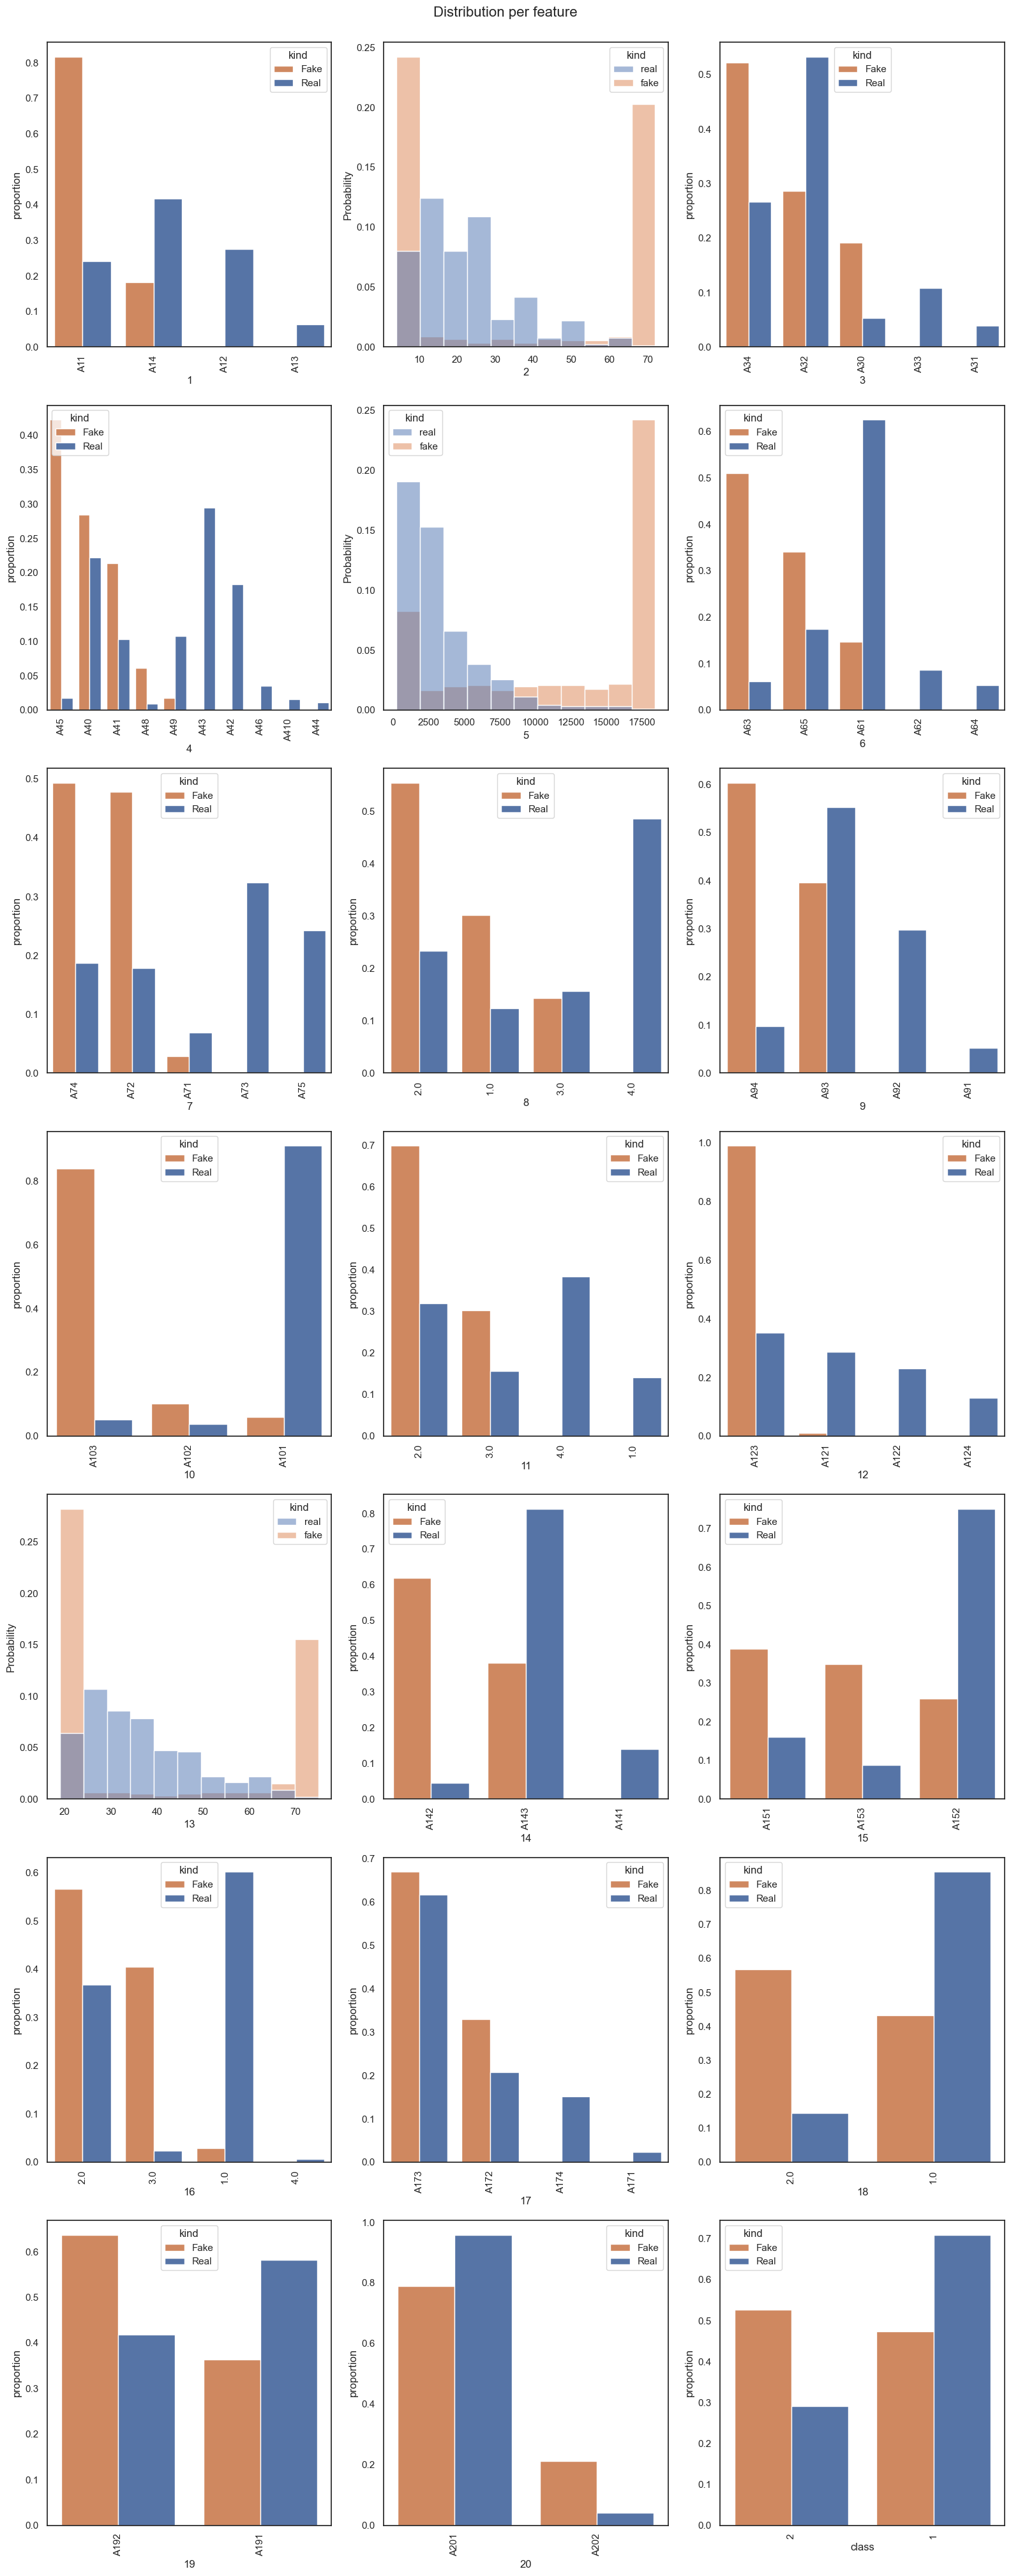

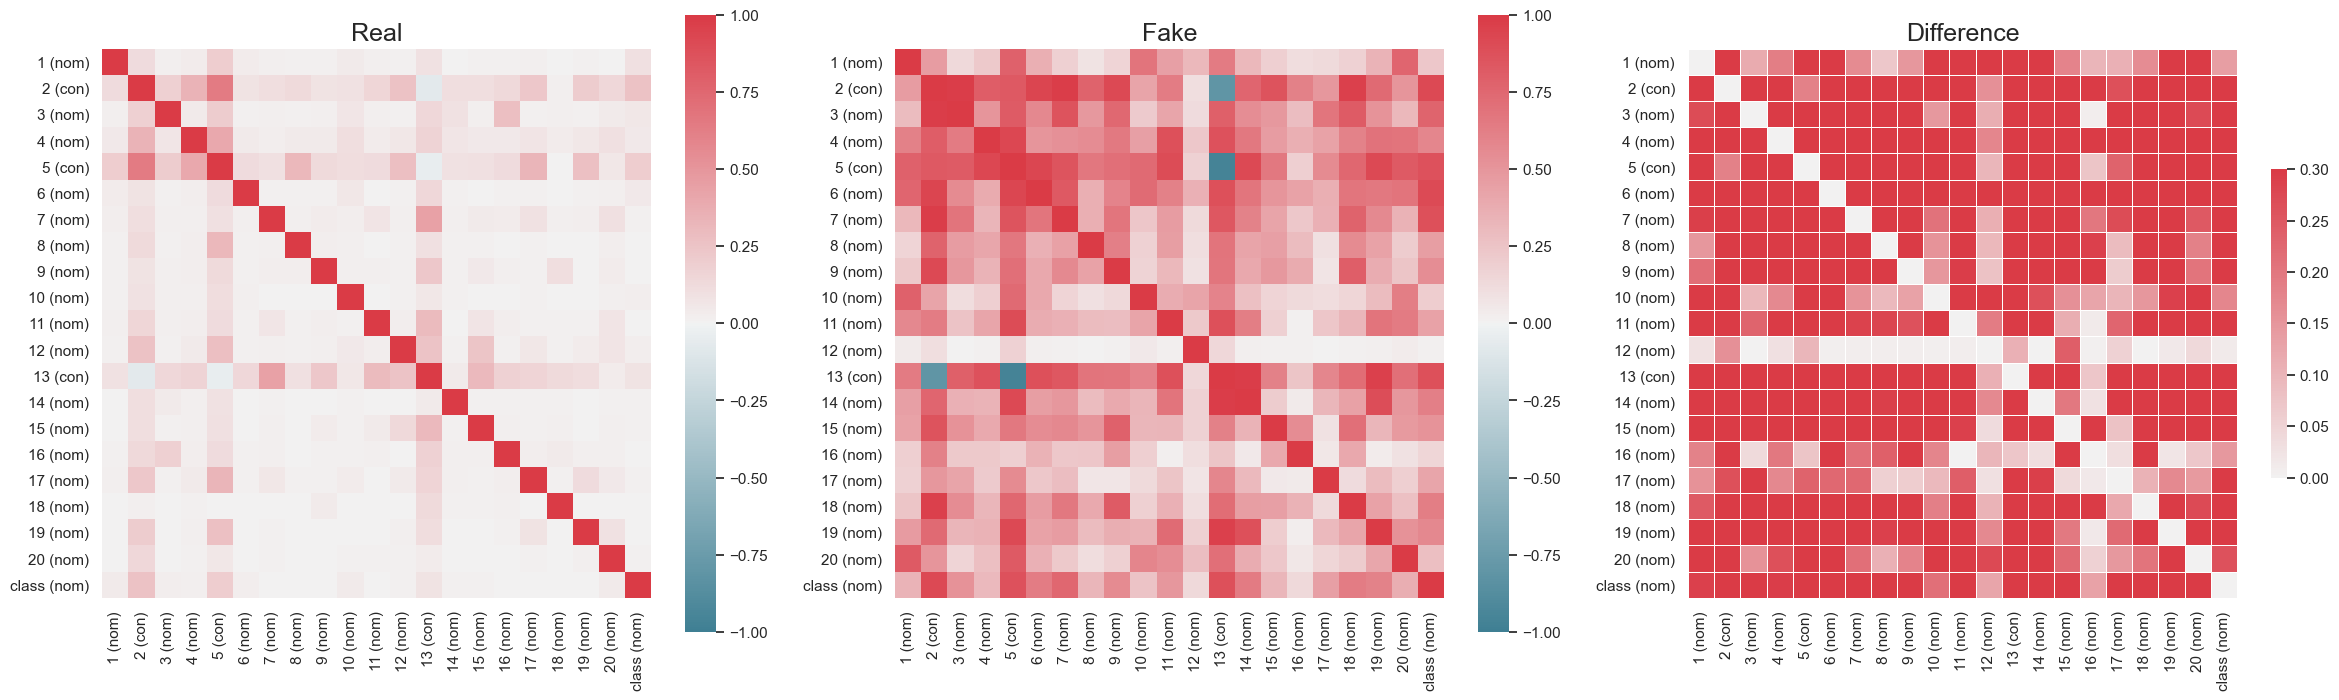

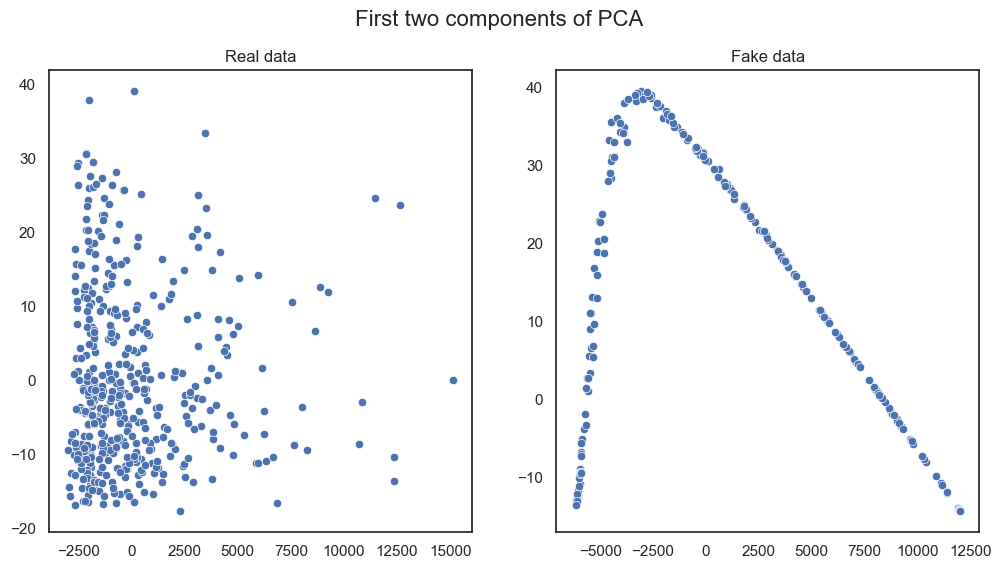


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.8022   0.9890              0.6852
DecisionTreeClassifier_real   0.6484   0.3407              0.1895
LogisticRegression_fake       0.5165   1.0000              0.3481
LogisticRegression_real       0.7582   0.7143              0.6396
MLPClassifier_fake            0.8352   0.9121              0.5965
MLPClassifier_real            0.5495   0.7363              0.3788
RandomForestClassifier_fake   0.5165   0.9890              0.3582
RandomForestClassifier_real   0.6923   0.7582              0.6697

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 2)
nearest neighbor mean                    4.3418
nearest neighbor std                     0.3557

Miscellaneous results:
                                  Result
Column Cor

In [60]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    g_credit_df, fooled.reset_index(drop=True),
    cat_cols = g_credit_cat_cols + ["class"]
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")